# **Разработка решения персонализации предложения постоянным клиентам с целью увеличения их покупательской активности**

**Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.**

**Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
Нужно собрать данные по клиентам по следующим группам:**
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

**В ходе выполнения проекта необходимо будет сделать следующее:**
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Имеем следующие данные:**
- `market_file.csv` (таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении);
- `market_money.csv` (таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом);
- `market_time.csv` (таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода);
- `money.csv` (таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю).

## Загрузка данных

In [1]:
!pip install phik -q

In [2]:
!pip install scikit-learn==1.1.3 -q

In [3]:
!pip install imbalanced-learn -q

In [4]:
!pip install shap -q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import phik
import math
import shap
from phik import resources, report
from phik.report import plot_correlation_matrix
from scipy import stats as st
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    roc_auc_score,
    make_scorer,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [6]:
data_main = pd.read_csv('/datasets/market_file.csv', sep = ',')
data_revenue = pd.read_csv('/datasets/market_money.csv', sep = ',')
data_time = pd.read_csv('/datasets/market_time.csv', sep = ',')
data_monthprof = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

In [7]:
def inf(df, r):
    df1=df.head(r)
    df2=df.info()
    return display(df1, df2)

In [8]:
inf(data_main, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   
5  215353                 Снизилась   стандартт                 да   
6  215354                 Снизилась   стандартт                 да   
7  215355                 Снизилась   стандартт                нет   
8  215356                 Снизилась   стандартт                 да   
9  215357                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   
7                 4.7                     4           284               0.17   
8                 4.2                     4           192               0.14   
9                 3.9                     5           154               0.00   

             Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    6   
1                Товары для детей                                    4   
2               Домашний текстиль                                    5   
3                Товары для детей                                    5   
4                Товары для детей                                    3   
5               Домашний текстиль                                    4   
6           Косметика и аксесуары                                    2   
7                Товары для детей                                    5   
8           Косметика и аксесуары                                    2   
9  Техника для красоты и здоровья                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2  
7                                   1               6                 4  
8                                   2               1                 3  
9                                   3               9                 5

None

In [9]:
inf(data_revenue, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
8  215350     предыдущий_месяц   5457.5
9  215351        текущий_месяц   6610.4

None

In [10]:
inf(data_time, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдцщий_месяц      8
6  215351     текущий_месяц     13
7  215351  предыдцщий_месяц     11
8  215352     текущий_месяц     11
9  215352  предыдцщий_месяц      8

None

In [11]:
inf(data_monthprof, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
5  215353     3.95
6  215354     3.62
7  215355     5.26
8  215356     4.93
9  215357     4.66

None

**Данные загружены, соответствуют описанию. Переходим к предобработке данных.**

## Предобработка данных

**В `data_main`, `data_revenue`, `data_time` и `data_monthprof` пропусков нет, типы данных в столбцах соответствуют находящимся в них данным. Наименования столбцов оставим киррилическими, однако приведём их к единому виду, устраним пробелы и обозначим для большей информативности единицы измерения, там где это нужно.**

In [12]:
data_main.columns = ['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность_дн',
       'Акционные_покупки_доля', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_квартал_шт', 'Ошибка_сервиса_шт',
       'Страниц_за_визит_шт']

In [13]:
data_main.head()

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность_дн  \
0                 3.4                     5              121   
1                 4.4                     4              819   
2                 4.9                     3              539   
3                 3.2                     5              896   
4                 5.1                     3             1064   

   Акционные_покупки_доля Популярная_категория  \
0                    0.00     Товары для детей   
1                    0.75     Товары для детей   
2                    0.14    Домашний текстиль   
3                    0.99     Товары для детей   
4                    0.94     Товары для детей   

   Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_квартал_шт  \
0                                    6                                 2   
1                                    4                                 4   
2                                    5                                 2   
3                                    5                                 0   
4                                    3                                 2   

   Ошибка_сервиса_шт  Страниц_за_визит_шт  
0                  1                    5  
1                  2                    5  
2                  1                    5  
3                  6                    4  
4                  3                    2

In [14]:
data_time.columns = ['id', 'Период', 'Время_на_сайте_минут']

In [15]:
data_time.head()

id            Период  Время_на_сайте_минут
0  215348     текущий_месяц                    14
1  215348  предыдцщий_месяц                    13
2  215349     текущий_месяц                    10
3  215349  предыдцщий_месяц                    12
4  215350     текущий_месяц                    13

**Проверим данные на наличие дубликатов.**

In [16]:
data_main.duplicated().sum()

0

In [17]:
data_revenue.duplicated().sum()

0

In [18]:
data_time.duplicated().sum()

0

In [19]:
data_monthprof.duplicated().sum()

0

**По столбцам с типами данных object рассмотрим уникальные значения для проверки на наличие неявных дубликатов.**

In [20]:
for n in ['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать','Популярная_категория']:
    display(sorted(data_main[n].unique()))

['Прежний уровень', 'Снизилась']

['премиум', 'стандарт', 'стандартт']

['да', 'нет']

['Домашний текстиль',
 'Косметика и аксесуары',
 'Кухонная посуда',
 'Мелкая бытовая техника и электроника',
 'Техника для красоты и здоровья',
 'Товары для детей']

In [21]:
sorted(data_revenue['Период'].unique())

['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']

In [22]:
sorted(data_time['Период'].unique())

['предыдцщий_месяц', 'текущий_месяц']

**Видим в столбце `Тип_сервиса` таблицы из `data_main` неявные дубликаты из-за опечатки. В остальных столбцах неявных дубликатов нет, однако есть опечатка в 'предыдцщий_месяц' в `data_time`, исправим.**

In [23]:
data_main['Тип_сервиса'] = data_main['Тип_сервиса'].replace('стандартт', 'стандарт')
data_time['Период'] = data_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [24]:
display(sorted(data_main['Тип_сервиса'].unique()))
display(sorted(data_time['Период'].unique()))

['премиум', 'стандарт']

['предыдущий_месяц', 'текущий_месяц']

**Неявные дубликаты устранены. Предобработка завершена, переходим к исследовательскому анализу данных.**

## Исследовательский анализ данных

**Проведём исследовательский анализ данных из каждой таблицы. Отберём клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.**

**Проведём статистический анализ всех признаков в таблицах, построим графики для каждого признака. Для количественных признаков построим гистограммы и "ящики с усами", а для категориальных признаков - круговую диаграмму.**

In [25]:
g1_hist = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность_дн',
           'Акционные_покупки_доля', 'Средний_просмотр_категорий_за_визит',
           'Неоплаченные_продукты_квартал_шт', 'Ошибка_сервиса_шт',
           'Страниц_за_визит_шт']
g2_hist = ['Среднемесячное значение маркетинговых коммуникаций компании за 6 мес',
           'Количество маркетинговых коммуникаций в текущем месяце', 
           'Длительность с момента регистрации, дней', 
           'Доля покупок по акции за 6 мес', 
           'Среднее количество просмотренных категорий за визит', 
           'Количество неоплаченных товаров в корзине за последние 3 мес',
           'Количество сбоев сайта во время посещения',
           'Cреднее количество страниц за  визит за последние 3 мес']
bins_hist = [30, 10, 30, 30, 12, 10, 15, 20]
def hist_1(g1_hist, g2_hist, bins_hist):
    for n in range(0,len(g1_hist)):
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 9), gridspec_kw={'height_ratios': [3, 1, 1]})
        for act in data_main['Покупательская_активность'].unique():
            subset = data_main[data_main['Покупательская_активность'] == act]
            #axes[0].hist(subset['Время_на_сайте_минут'], bins=40, alpha=0.5, label=period)
            ax[0].hist(subset[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='black', label=act)
            ax[0].set_title(f'Гистограмма и "ящик с усами" для признака \n{g2_hist[n]}', fontsize=14)
            ax[0].set_ylabel('Количество', fontsize=12)
            ax[0].grid(True)
            ax[0].legend()
        uniq = data_main['Покупательская_активность'].unique()
        ax[1].boxplot(data_main[data_main['Покупательская_активность']==uniq[0]][g1_hist[n]], vert=False, widths=0.7)
        ax[1].set_xlabel(f'{g2_hist[n]} \n(покупательская активность - {uniq[0]})', fontsize=12)
        ax[2].boxplot(data_main[data_main['Покупательская_активность']==uniq[1]][g1_hist[n]], vert=False, widths=0.7)
        ax[2].set_xlabel(f'{g2_hist[n]} \n(покупательская активность - {uniq[1]})', fontsize=12)
        plt.tight_layout()
        plt.show()
        display(data_main[g1_hist[n]].describe())
        display(80*'*')
    return

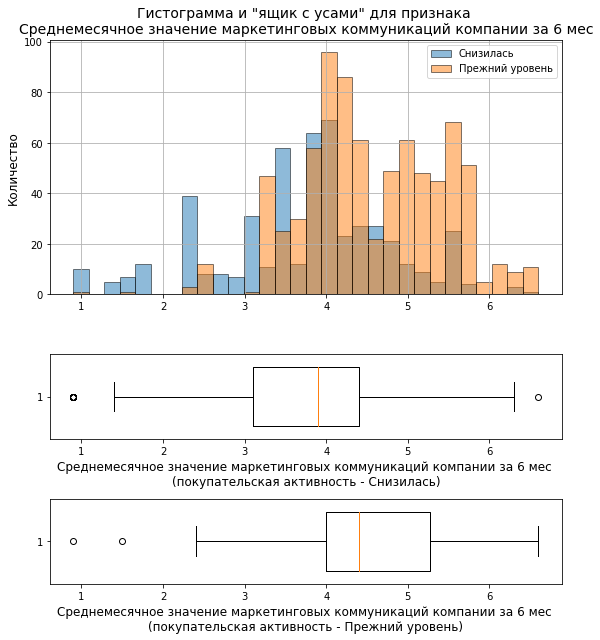

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

'********************************************************************************'

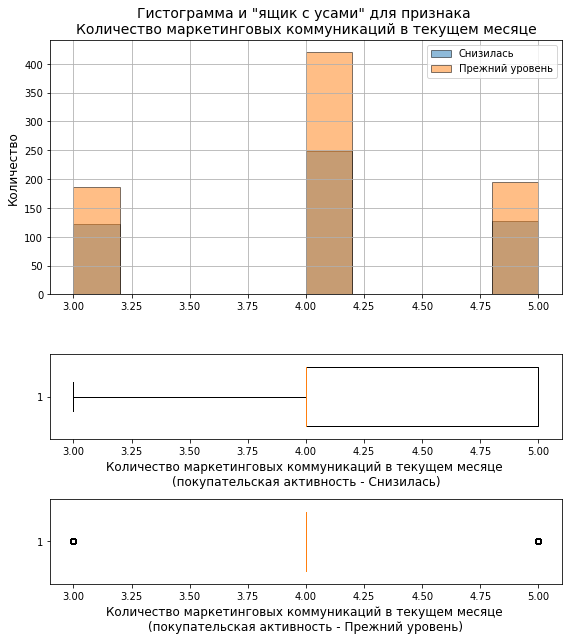

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

'********************************************************************************'

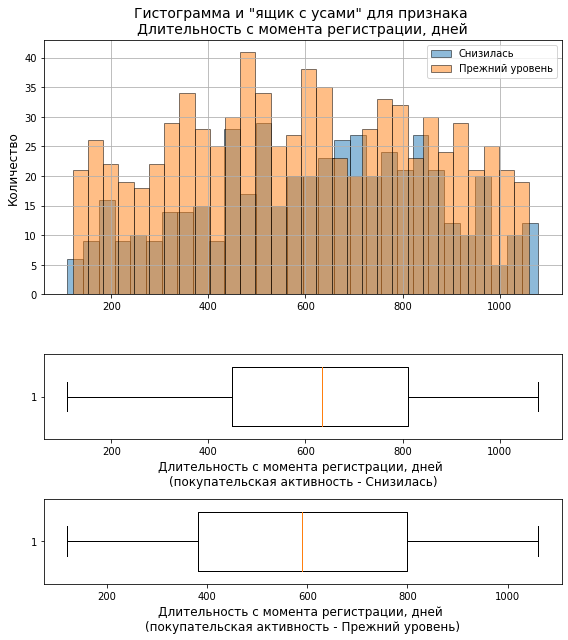

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность_дн, dtype: float64

'********************************************************************************'

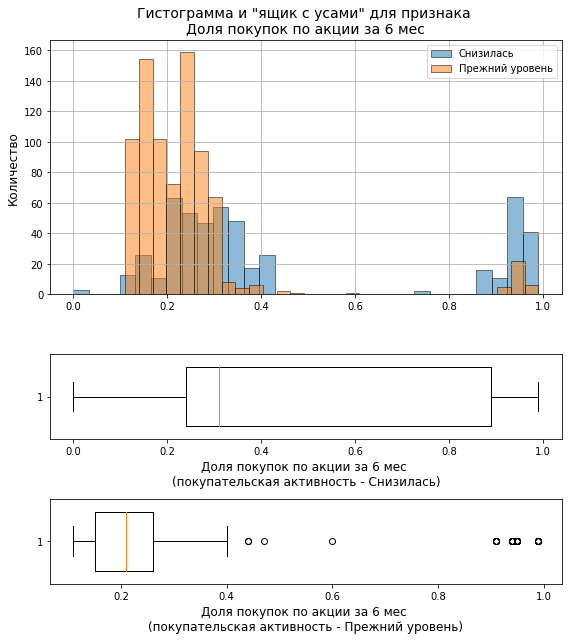

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки_доля, dtype: float64

'********************************************************************************'

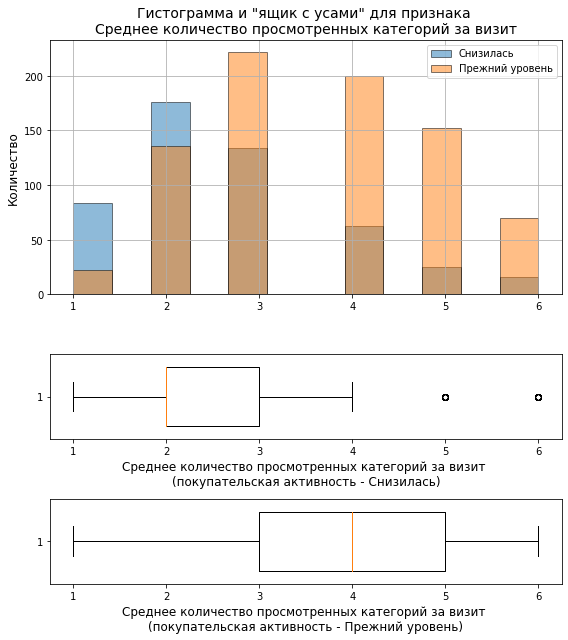

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

'********************************************************************************'

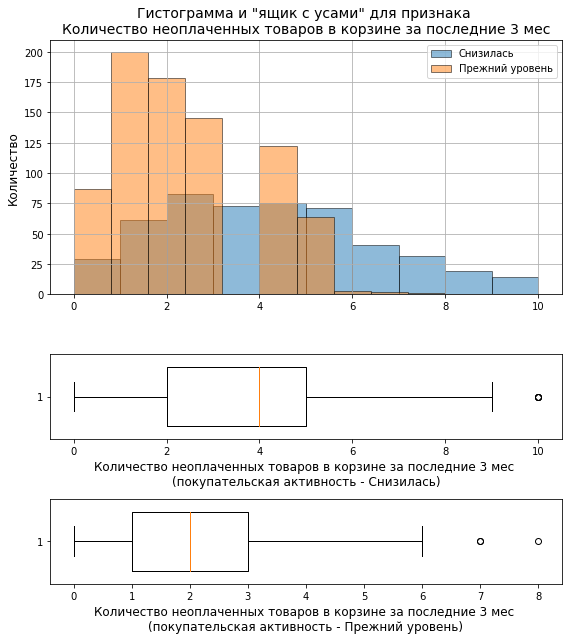

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_квартал_шт, dtype: float64

'********************************************************************************'

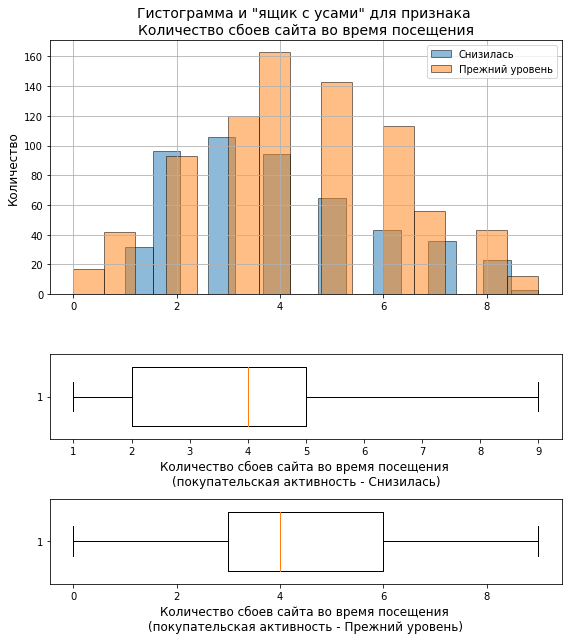

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса_шт, dtype: float64

'********************************************************************************'

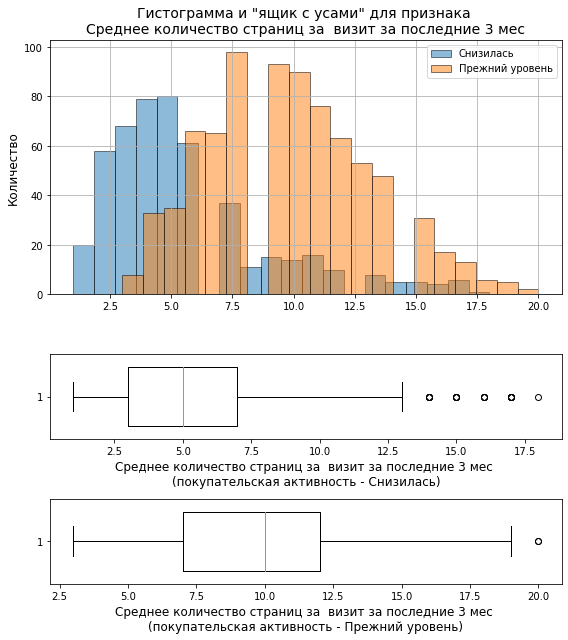

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит_шт, dtype: float64

'********************************************************************************'

In [26]:
hist_1(g1_hist, g2_hist, bins_hist)

**По круговым диаграммам, гистограммам и "ящикам с усами" видим следующее:**
- из 5 отделов преобладает отдел sales (37.9%)
- по уровню занимаемой должности работники примерно одинаково, с небольшой разницей, распределены по уровню junior и middle (47% и 43%) и 9% отводится уровню senior.
- по уровню загруженности работника более половины работников имеют загрузку medium.
- Гистограмма по длительности работы в компании имеет вид распределения Пуассона с пиком около 1, среднее и медианные значения не сильно отличаются друг от друга, стандартное отклонение умеренное, выбросов нет.
- 97% работников не получали повышения за последний год
- 86% работников не допускали нарушений трудового договора за последний год
- Гистограмма по оценке работника руководителем имеет вид распределения Пуассона с пиком около 4, значения распределены дискретно от 1 до 5, среднее и медианные значения не сильно отличаются друг от друга, стандартное отклонение умеренное.**

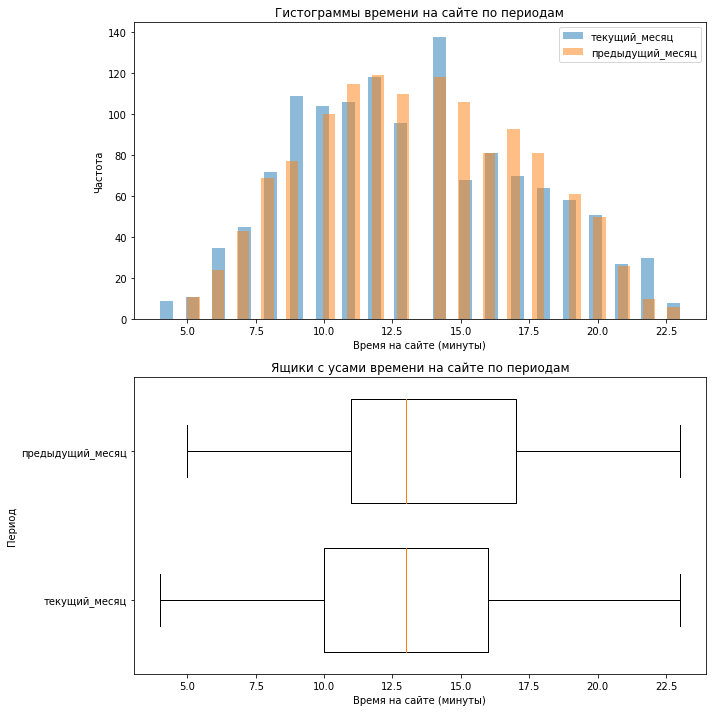

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for period in data_time['Период'].unique():
    subset = data_time[data_time['Период'] == period]
    axes[0].hist(subset['Время_на_сайте_минут'], bins=40, alpha=0.5, label=period)
axes[0].set_xlabel('Время на сайте (минуты)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Гистограммы времени на сайте по периодам')
axes[0].legend()
boxpl = [data_time[data_time['Период'] == period]['Время_на_сайте_минут'] for period in data_time['Период'].unique()]
axes[1].boxplot(boxpl, labels=data_time['Период'].unique(), vert=False, widths=0.7)
axes[1].set_ylabel('Период')
axes[1].set_xlabel('Время на сайте (минуты)')
axes[1].set_title('Ящики с усами времени на сайте по периодам')

plt.tight_layout()
plt.show()

In [29]:
for period in data_time['Период'].unique():
   display(f'{period}:', data_time[data_time['Период'] == period]['Время_на_сайте_минут'].describe())

'текущий_месяц:'

count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: Время_на_сайте_минут, dtype: float64

'предыдущий_месяц:'

count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: Время_на_сайте_минут, dtype: float64

**Гистограммы по Времени на сайте и в текущем, и в прошлом периоде схожи и имеют вид распределения Пуассона, близкого к нормальному, средние и медианные значения не сильно отличаются друг от друга, стандартное отклонение умеренное, выбросов нет.**

In [30]:
def hist_rev():
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    for period in data_revenue['Период'].unique():
        subset = data_revenue[data_revenue['Период'] == period]
        axes[0].hist(subset['Выручка'], bins=40, alpha=0.5, label=period)
    axes[0].set_xlabel('Выручка')
    axes[0].set_ylabel('Частота')
    axes[0].set_title('Гистограммы выручки по периодам')
    axes[0].legend()
    axes[0].grid()
    boxpl = [data_revenue[data_revenue['Период'] == period]['Выручка'] for period in data_revenue['Период'].unique()]
    axes[1].boxplot(boxpl, labels=data_revenue['Период'].unique(), vert=False, widths=0.7)
    axes[1].set_ylabel('Период')
    axes[1].set_xlabel('Выручка')
    axes[1].set_title('Ящики с усами выручки по периодам')
    axes[1].grid()

    plt.tight_layout()
    plt.show()

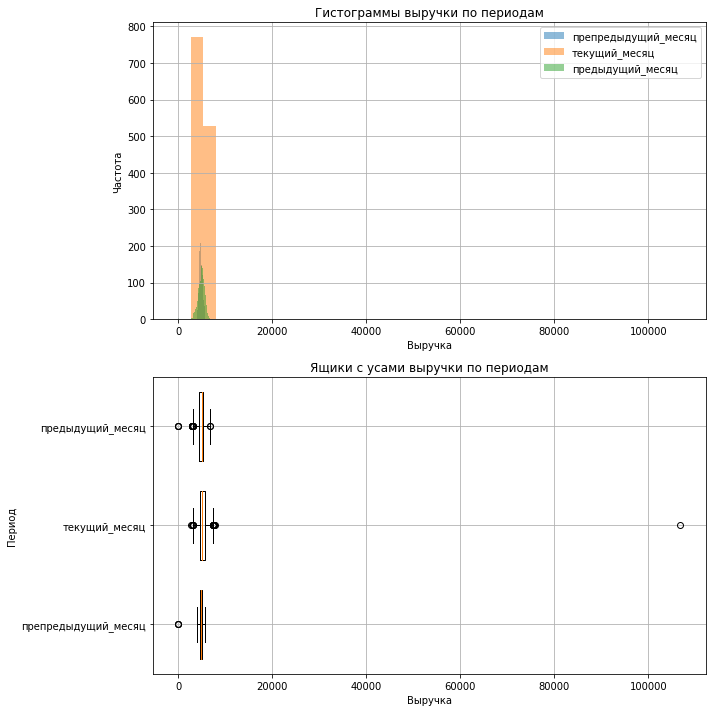

In [31]:
hist_rev()

In [32]:
for period in data_revenue['Период'].unique():
   display(f'{period}:', data_revenue[data_revenue['Период'] == period]['Выручка'].describe())

'препредыдущий_месяц:'

count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: Выручка, dtype: float64

'текущий_месяц:'

count      1300.000000
mean       5314.960846
std        2939.708156
min        2758.700000
25%        4706.050000
50%        5179.950000
75%        5761.725000
max      106862.200000
Name: Выручка, dtype: float64

'предыдущий_месяц:'

count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: Выручка, dtype: float64

**Видим выброс в текущем месяце. Удалим значения выше 10000.**

In [33]:
data_revenue=data_revenue.query('Выручка<10000')

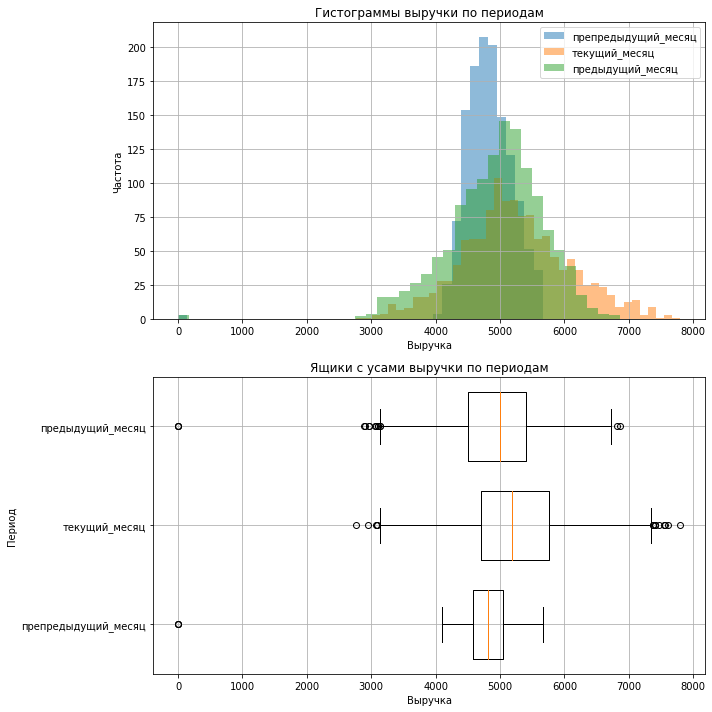

In [34]:
hist_rev()

In [35]:
for period in data_revenue['Период'].unique():
   display(f'{period}:', data_revenue[data_revenue['Период'] == period]['Выручка'].describe())

'препредыдущий_месяц:'

count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: Выручка, dtype: float64

'текущий_месяц:'

count    1299.000000
mean     5236.787452
std       835.474686
min      2758.700000
25%      4705.500000
50%      5179.600000
75%      5759.950000
max      7799.400000
Name: Выручка, dtype: float64

'предыдущий_месяц:'

count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: Выручка, dtype: float64

**Гистограммы по Выручке по периодам имеют нормальное распределение, средние и медианные значения не сильно отличаются друг от друга, стандартные отклонения умеренные. "Ящики с усами" показывают выбросы, однако значения Выручки, равные 0, нам важны для дальнейшего анализа, а остальные отклонения незначительны, поэтому удалять эти выбросы не будем.**

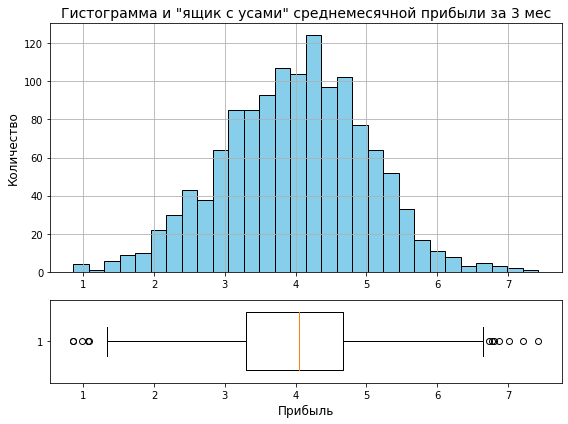

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

In [36]:
data_monthprof
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})
ax[0].hist(data_monthprof['Прибыль'], bins=30, color='skyblue', edgecolor='black')
ax[0].set_title(f'Гистограмма и "ящик с усами" среднемесячной прибыли за 3 мес', fontsize=14)
ax[0].set_ylabel('Количество', fontsize=12)
ax[0].grid(True)
ax[1].boxplot(data_monthprof['Прибыль'], vert=False, widths=0.7)
ax[1].set_xlabel('Прибыль', fontsize=12)
plt.tight_layout()
plt.show()
display(data_monthprof['Прибыль'].describe())

**Гистограммы по среднемесячной прибыли за 3 месяца имеет нормальное распределение, средние и медианные значения не сильно отличаются друг от друга, стандартные отклонения умеренные.**

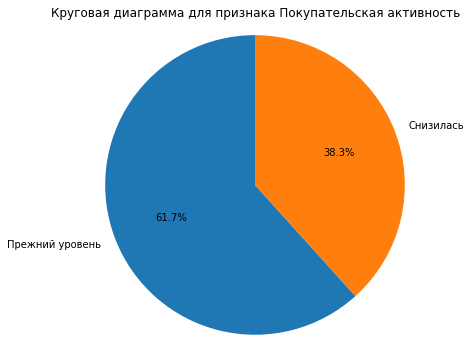

In [38]:
data = data_main['Покупательская_активность'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
plt.title(f'Круговая диаграмма для признака Покупательская активность')
plt.axis('equal')  
plt.show()

In [39]:
g1_pie = ['Тип_сервиса', 'Разрешить_сообщать','Популярная_категория']
g2_pie = ['Тип сервиса', 'Согласие на рассылку предложений',
          'Популярная категория товаров за последние 6 мес']

def pie_1(g1_pie, g2_pie):
    for n in range(len(g1_pie)):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  
        for i, act in enumerate(data_main['Покупательская_активность'].unique()):
            subset = data_main[data_main['Покупательская_активность'] == act]
            data = subset[g1_pie[n]].value_counts()
            ax[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
            ax[i].set_title(f'Покупательская активность: {act}')  
            ax[i].axis('equal')  
        plt.suptitle(f'Круговая диаграмма для признака {g2_pie[n]}')  
        plt.show()

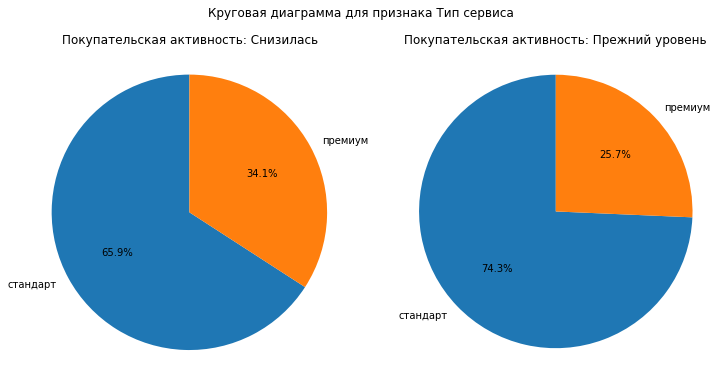

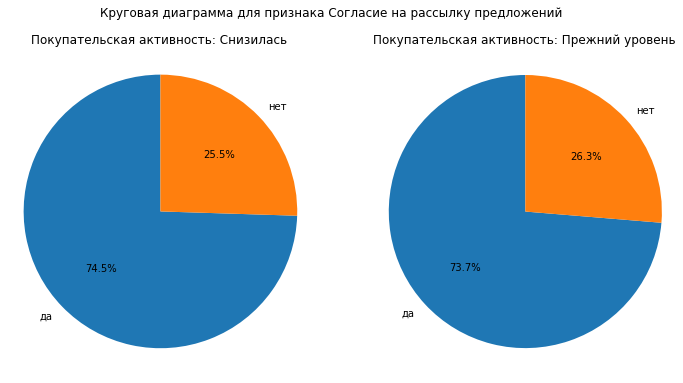

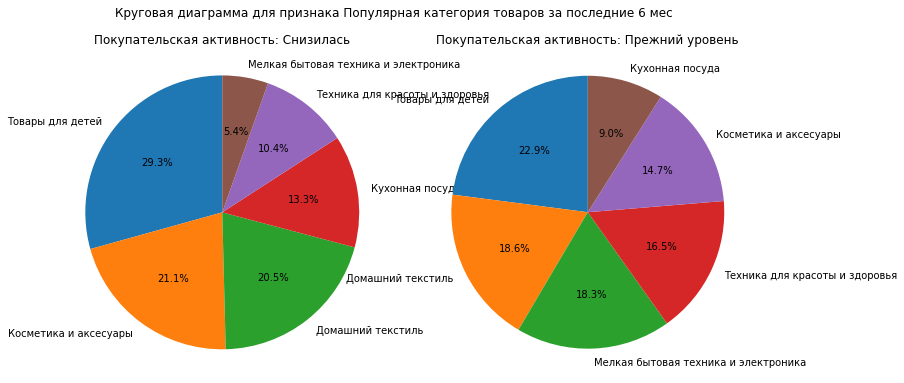

In [40]:
pie_1(g1_pie, g2_pie)

**По круговым диаграммам можно сказать следующее:**
- Покупательская активность большинства покупателей осталась на прежнем уровне, однако у 38% она снизилась.
- По типу сервиса большинство имеют тип Стандарт. У сегмента покупателей со снижением покупательской аткивности доля покупателей с типом сервиса "Премиум" больше, чем у активных.
- Отношение покупателей, давших согласие на рассылку предложений к тем, кто не дал, 3:1.
- По популярности категорий товаров за 6 месяцев на первом месте находится категория товаров для детей. Наблюдается некоторая особенность по категориям товаров у покупателей со снижением покупательской активности и у активных покупателей. Доля покупателей со снижением покупательской активности заметно ниже в категории "мелкая бытовая техника и электроника", доля сегмента различается более чем в 3 раза, и в "техника для красоты и здоровья", ниже в 1.5 раза, при этом большая доля по сравнению с активными покупателями в категориях "товары для детей", "кухонная посуда" и "косметика и аксессуары"

**Проверим объём потери данных после удаления выбросов.**

In [41]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность_дн                      1300 non-null   int64  
 7   Акционные_покупки_доля               1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_квартал_шт     1300 non-null   int64  
 11  Ошибка_сервиса_шт             

In [42]:
data_monthprof.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Потери данных небольшие. Отберём клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Для этого воспользуемся данными из `data_revenue`. По задаче, поставленной заказчиком не совсем понятно, требуется отобрать покупателей, которые совершили первую покупку не менее 3 месяцев назад или покупатели, которые в каждом из 3 месяцев совершали покупки, однако предположим, что в данном случае заказчику более важны постоянные покупатели, которые делают покупки регулярно продолжительный период, поэтому отберём покупателей, у которых выручка в каждом из трёх периодов не равна 0.**

In [43]:
data_revenue_id_to_remove = data_revenue[data_revenue['Выручка']==0]['id'].unique()

In [44]:
data_revenue_id_to_remove

array([215348, 215357, 215359])

In [45]:
data_revenue_active = data_revenue[~data_revenue['id'].isin(data_revenue_id_to_remove)]

**Это таблица с данными клиентов с активностью не менее 3 месяцев. Неподходящих под критерии отбора покупателей оказалось только 3.**

**Исследовательский анализ данных завершён. Мы исследовали признаки по всем таблицам, удалили выбросы, а также отобрали покупателей с активностью не менее 3 месяцев. По целевому признаку (покупательская активность) в ходе исследовательского анализа замечены следующие закономерности, которыми выделяются покупатели со снижением покупательской активности:**
- У гистограммы доли акционных покупок сегмента покупателей со снижением покупательской активности второй пик (приближенный к 1) имеет высоту больше активных покупателей, в то время как основной пик у активных покупателей больше. Это говорит о том, что основная масса покупателей, у которых доля покупок по акции близка к 1, сосредоточена в сегменте покупателей со сниженной покупательской активностью.
- большая доля по сравнению с активными покупателями в категориях "товары для детей", "кухонная посуда" и "косметика и аксессуары"
- У сегмента покупателей со снижением покупательской аткивности доля покупателей с типом сервса "Премиум" больше, чем у активных.


## Объединение таблиц

**Объединим таблицы `data_main`, `data_revenue` и `data_time`. Преобразуем сначала `data_revenue` и `data_time`, чтобы для каждого id данные были в одной строке, а для каждого периода был отдельный стоблец.**

In [46]:
data_revenue_mod = data_revenue_active.pivot(index='id', columns='Период', values='Выручка')
data_revenue_mod.columns = [f'Выручка_за_{col}' for col in data_revenue_mod.columns]
data_revenue_mod = data_revenue_mod.reset_index()

In [47]:
data_revenue_mod.head()

id  Выручка_за_предыдущий_месяц  Выручка_за_препредыдущий_месяц  \
0  215349                       5216.0                          4472.0   
1  215350                       5457.5                          4826.0   
2  215351                       6158.0                          4793.0   
3  215352                       5807.5                          4594.0   
4  215353                       4738.5                          5124.0   

   Выручка_за_текущий_месяц  
0                    4971.6  
1                    5058.4  
2                    6610.4  
3                    5872.5  
4                    5388.5

In [48]:
data_revenue_mod = data_revenue_mod[['id', 'Выручка_за_препредыдущий_месяц', 
                                     'Выручка_за_предыдущий_месяц', 'Выручка_за_текущий_месяц']]

In [49]:
data_revenue_mod.head()

id  Выручка_за_препредыдущий_месяц  Выручка_за_предыдущий_месяц  \
0  215349                          4472.0                       5216.0   
1  215350                          4826.0                       5457.5   
2  215351                          4793.0                       6158.0   
3  215352                          4594.0                       5807.5   
4  215353                          5124.0                       4738.5   

   Выручка_за_текущий_месяц  
0                    4971.6  
1                    5058.4  
2                    6610.4  
3                    5872.5  
4                    5388.5

In [50]:
data_time_mod = data_time.pivot(index='id', columns='Период', values='Время_на_сайте_минут')
data_time_mod.columns = [f'Минут_в_{col}' for col in data_time_mod.columns]
data_time_mod = data_time_mod.reset_index()

In [51]:
data_time_mod.head()

id  Минут_в_предыдущий_месяц  Минут_в_текущий_месяц
0  215348                        13                     14
1  215349                        12                     10
2  215350                         8                     13
3  215351                        11                     13
4  215352                         8                     11

**Теперь объединим таблицы.**

In [52]:
data_main = (data_main
             .merge(data_revenue_mod, on='id', how='inner')
             .merge(data_time_mod, on='id', how='inner')
)

In [53]:
data_main = data_main.dropna(subset=['Выручка_за_текущий_месяц'])

In [54]:
inf(data_main, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Разрешить_сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность_дн                      1296 non-null   int64  
 7   Акционные_покупки_доля               1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_квартал_шт     1296 non-null   int64  
 11  Ошибка_сервиса_шт             

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность_дн  \
0                 4.4                     4              819   
1                 4.9                     3              539   
2                 3.2                     5              896   
3                 5.1                     3             1064   
4                 3.3                     4              762   

   Акционные_покупки_доля Популярная_категория  \
0                    0.75     Товары для детей   
1                    0.14    Домашний текстиль   
2                    0.99     Товары для детей   
3                    0.94     Товары для детей   
4                    0.26    Домашний текстиль   

   Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_квартал_шт  \
0                                    4                                 4   
1                                    5                                 2   
2                                    5                                 0   
3                                    3                                 2   
4                                    4                                 1   

   Ошибка_сервиса_шт  Страниц_за_визит_шт  Выручка_за_препредыдущий_месяц  \
0                  2                    5                          4472.0   
1                  1                    5                          4826.0   
2                  6                    4                          4793.0   
3                  3                    2                          4594.0   
4                  1                    4                          5124.0   

   Выручка_за_предыдущий_месяц  Выручка_за_текущий_месяц  \
0                       5216.0                    4971.6   
1                       5457.5                    5058.4   
2                       6158.0                    6610.4   
3                       5807.5                    5872.5   
4                       4738.5                    5388.5   

   Минут_в_предыдущий_месяц  Минут_в_текущий_месяц  
0                        12                     10  
1                         8                     13  
2                        11                     13  
3                         8                     11  
4                        10                     10

None

**В итоговой объединенной таблице после предобработки данных, удаления выбросов и объединения с другими таблицами по пересечению id, получилась потеря только 4 строк, это для нас допустимые потери. Переходим к следующему шагу.**

##  Корреляционный анализ

**Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования.**

**Изучим взаимосвязи между признаками:  рассчитаем коэффициенты корреляции между всеми признакам и, так как не все признаки распределены нормально, построим матрицы корреляций Phik.**

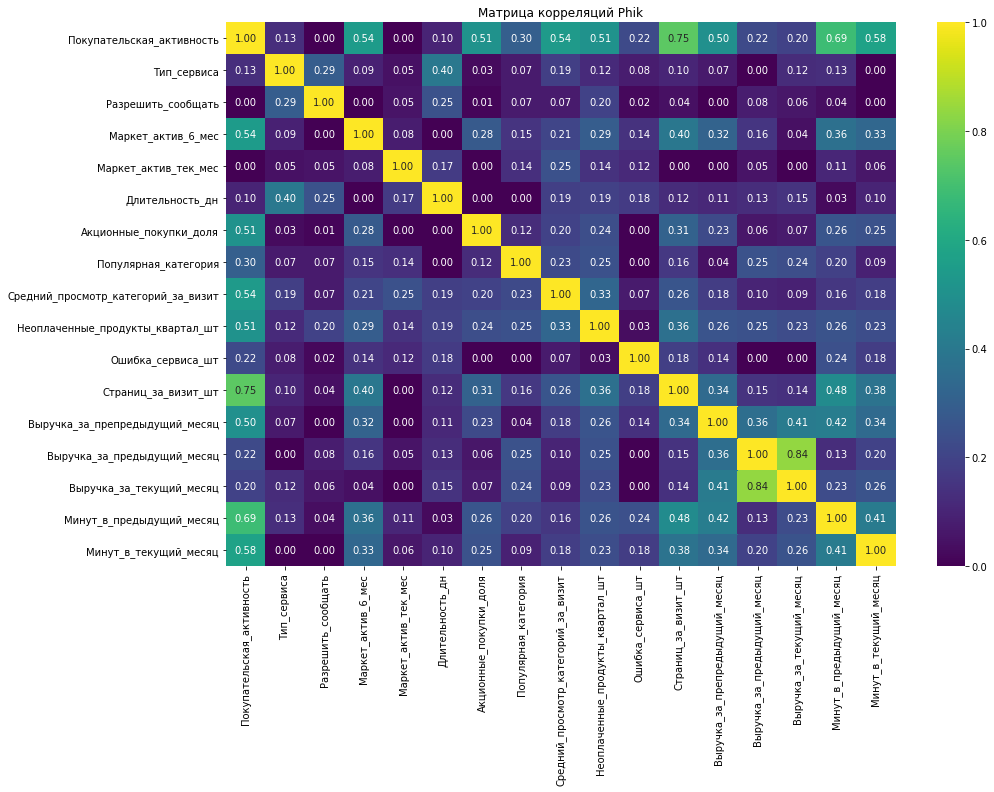

In [55]:
phik_cols = ['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
             'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность_дн',
             'Акционные_покупки_доля', 'Популярная_категория',
             'Средний_просмотр_категорий_за_визит',
             'Неоплаченные_продукты_квартал_шт', 'Ошибка_сервиса_шт',
             'Страниц_за_визит_шт', 'Выручка_за_препредыдущий_месяц',
             'Выручка_за_предыдущий_месяц', 'Выручка_за_текущий_месяц',
             'Минут_в_предыдущий_месяц', 'Минут_в_текущий_месяц']
phik_corr_matrix = (data_main[phik_cols]
                    .phik_matrix(interval_cols=['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 
                                                'Длительность_дн', 'Акционные_покупки_доля', 
                                                'Средний_просмотр_категорий_за_визит',
                                                'Неоплаченные_продукты_квартал_шт', 
                                                'Ошибка_сервиса_шт', 'Страниц_за_визит_шт', 
                                                'Выручка_за_препредыдущий_месяц', 
                                                'Выручка_за_предыдущий_месяц', 'Выручка_за_текущий_месяц',
                                                'Минут_в_предыдущий_месяц', 'Минут_в_текущий_месяц'])
)
plt.figure(figsize=(15, 10))
sns.heatmap(phik_corr_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Матрица корреляций Phik')
plt.show()

**По матрице корреляции видим следующие взаимосвязи:**
- средний уровень корреляции покупательской активности с:
    - долей акционных покупок, 
    - среднемесячным значением маркетинговых коммуникаций на покупателя за последние 6 месяцев
    - средним просмотром категорий за визит
    - количеством неоплаченных продуктов за квартал
    - выручкой за препредыдущий месяц
- высокий уровень корреляции покупательской активности с:
    - средним количеством просмотренных страниц за визит
    - временем, проведённом на сайте в текущем и предыдущем периоде

**Также наблюдается высокий уровень коллинеарности (0.84) между выручкой за текущий и предыдущий период. Про мультиколлинеарность обычно говорят при значениях корреляции выше 0.9, поэтому в данном случае про мультиколлинеарность мы не говорим.**

##  Использование пайплайнов

**Применим все изученные модели. Для этого используем пайплайны. Целевой признак (покупательская активность) несбалансирован, покупателей с прежним уровнем активности почти в 2 раза больше, чем со сниженным, поэтому будем использовать метрику ROC-AUC**

In [56]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

label_encoder = LabelEncoder()
data_main['Покупательская_активность'] = label_encoder.fit_transform(data_main['Покупательская_активность'])

X_train, X_test, y_train, y_test = train_test_split(
    data_main.drop(columns=['Покупательская_активность', 'id'], axis=1),
    data_main['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_main['Покупательская_активность'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['Тип_сервиса', 'Разрешить_сообщать']
ord_columns = ['Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность_дн', 'Акционные_покупки_доля', 
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_квартал_шт', 'Ошибка_сервиса_шт', 
               'Страниц_за_визит_шт', 'Выручка_за_препредыдущий_месяц', 'Выручка_за_предыдущий_месяц', 
               'Выручка_за_текущий_месяц', 'Минут_в_предыдущий_месяц', 'Минут_в_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'sigmoid', 'poly', 'rbf'],
        'models__degree': range(2, 6),
        'models__C': np.linspace(0.1, 1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
#y_test_pred = randomized_search.predict(X_test) 
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')
print(f'Параметры лучшей модели: {randomized_search.best_params_}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                                 

**Было обучено 4 модели:**
- KNeighborsClassifier(), 
- DecisionTreeClassifier(), 
- LogisticRegression() 
- SVC(). 

**Для каждой из моделей были подобраны гиперпараметры.  Во время подготовки данных был использован ColumnTransformer. Количественные и категориальные признаки обработаны в пайплайне раздельно. Для кодирования категориальных признаков использованы OneHotEncoder и OrdinalEncoder, для масштабирования количественных — StandardScaler и MinMaxScaler.**
**Лучшей моделью оказался метод опорных векторов (SVC) с параметрами:**
- Ядро радиальной базисной функции (RBF)
- параметр регуляризации С = 0.3
- probability=True
- метод масштабирования StandardScaler()

**Метрика лучшей модели на тренировочной выборке: 0.8986125599278173**

**Метрика ROC-AUC на тестовой выборке: 0.90875**

##  Анализ важности признаков

**Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.**

In [57]:
PA_cod = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f'Расшифровка кодировки целевого признака "Покупательская активность": {PA_cod}')

Расшифровка кодировки целевого признака "Покупательская активность": {'Прежний уровень': 0, 'Снизилась': 1}


In [58]:
display(randomized_search.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer...
                                                   'Акционные_покупки_доля',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_квартал_шт',
                                                   'Ошибка_сервиса_шт',
                                                   'Страниц_за_визит_шт',
                                                   'Выручка_за_препредыдущий_месяц',
                                                   'Выручка_за_предыдущий_месяц',
                                                   'Выручка_за_текущий_месяц',
                                                   'Минут_в_предыдущий_месяц',
                                                   'Минут_в_текущий_месяц'])])),
                ('models',
                 SVC(C=0.30000000000000004, probability=True,
                     random_state=42))])

In [59]:
best = randomized_search.best_estimator_
best_model = best.named_steps['models']

In [60]:
X_train_scaled = best.named_steps['preprocessor'].transform(X_train)
X_test_scaled = best.named_steps['preprocessor'].transform(X_test)

feature_names = best.named_steps['preprocessor'].get_feature_names_out()

In [61]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)

In [62]:
X_train_sampled_df = shap.sample(X_train_scaled_df, 100)

# Создаем объяснитель для модели SVC
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_sampled_df, link="logit")

In [63]:
X_test_scaled_df.head()

ohe__Тип_сервиса_стандарт  ohe__Разрешить_сообщать_нет  \
0                        1.0                          0.0   
1                        0.0                          1.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        1.0                          1.0   

   ord__Популярная_категория  num__Маркет_актив_6_мес  \
0                        4.0                -0.169629   
1                        5.0                -2.866015   
2                        0.0                -0.968558   
3                        0.0                -0.768826   
4                        3.0                 1.228498   

   num__Маркет_актив_тек_мес  num__Длительность_дн  \
0                  -0.034940             -0.003856   
1                  -0.034940              0.307182   
2                  -0.034940             -0.474402   
3                  -1.450017              1.794585   
4                  -0.034940             -1.834199   

   num__Акционные_покупки_доля  num__Средний_просмотр_категорий_за_визит  \
0                    -0.678649                                  2.045527   
1                     2.517826                                 -0.183455   
2                    -0.759573                                  0.559539   
3                     0.130585                                  0.559539   
4                     2.720134                                 -1.669444   

   num__Неоплаченные_продукты_квартал_шт  num__Ошибка_сервиса_шт  \
0                              -0.927589               -0.099707   
1                               1.542593               -1.646221   
2                              -0.433553                1.962313   
3                               0.060484                0.415798   
4                              -0.433553               -0.615212   

   num__Страниц_за_визит_шт  num__Выручка_за_препредыдущий_месяц  \
0                  0.961202                             0.214194   
1                 -0.557143                            -0.540665   
2                  0.455087                            -0.808993   
3                 -0.557143                             0.453036   
4                 -0.304085                            -1.145141   

   num__Выручка_за_предыдущий_месяц  num__Выручка_за_текущий_месяц  \
0                         -1.405144                      -2.320463   
1                         -2.013227                      -1.271572   
2                          0.699537                       1.304666   
3                          2.359246                       1.807872   
4                          0.193040                       0.635946   

   num__Минут_в_предыдущий_месяц  num__Минут_в_текущий_месяц  
0                       0.624051                    0.894668  
1                      -0.647600                   -1.024488  
2                       1.641373                   -0.544699  
3                      -1.156261                   -1.024488  
4                       0.369721                    1.134563

In [64]:
X_train_scaled_df.head()

ohe__Тип_сервиса_стандарт  ohe__Разрешить_сообщать_нет  \
0                        1.0                          0.0   
1                        1.0                          0.0   
2                        1.0                          0.0   
3                        1.0                          0.0   
4                        0.0                          0.0   

   ord__Популярная_категория  num__Маркет_актив_6_мес  \
0                        3.0                 1.228498   
1                        4.0                 0.829033   
2                        3.0                 0.030104   
3                        2.0                 1.328364   
4                        5.0                -0.668960   

   num__Маркет_актив_тек_мес  num__Длительность_дн  \
0                  -0.034940             -0.386673   
1                  -0.034940             -1.626840   
2                   1.380136              1.555325   
3                  -0.034940             -1.056603   
4                   1.380136              1.060853   

   num__Акционные_покупки_доля  num__Средний_просмотр_категорий_за_визит  \
0                    -0.678649                                 -0.926450   
1                    -0.354956                                  0.559539   
2                    -0.597726                                  1.302533   
3                     2.517826                                 -0.926450   
4                     0.292432                                 -0.183455   

   num__Неоплаченные_продукты_квартал_шт  num__Ошибка_сервиса_шт  \
0                               0.554520                1.446808   
1                               1.048557               -1.130716   
2                              -0.927589               -0.615212   
3                               2.036630                0.415798   
4                              -0.433553               -1.130716   

   num__Страниц_за_визит_шт  num__Выручка_за_препредыдущий_месяц  \
0                  1.973431                            -1.451803   
1                 -1.316315                            -0.714636   
2                  0.708144                            -0.629125   
3                 -0.051028                             1.266868   
4                 -0.810200                            -0.437461   

   num__Выручка_за_предыдущий_месяц  num__Выручка_за_текущий_месяц  \
0                          0.308218                       0.921997   
1                          2.067366                      -1.724921   
2                         -1.204835                      -1.714569   
3                         -0.035885                      -0.562990   
4                         -1.772856                      -0.760751   

   num__Минут_в_предыдущий_месяц  num__Минут_в_текущий_месяц  
0                       1.641373                   -1.744172  
1                      -0.647600                   -0.064910  
2                      -0.138940                   -0.784593  
3                       0.115391                    1.374458  
4                      -0.901931                   -0.784593

In [65]:
X_test_sampled_df = shap.sample(X_test_scaled_df, 10)

**Чтобы избавиться от необходимости длительного ожидания выполнения кода при повторных запусках, здесь в коде используются данные 10 покупателей. Ниже, после графиков, приложены скриншоты таких же графиков, но построенных на основании данных 100 покупателей.**

In [66]:
# Вычисляем SHAP-значения для тестового набора данных
shap_values = explainer.shap_values(X_test_sampled_df)

  0%|          | 0/10 [00:00<?, ?it/s]

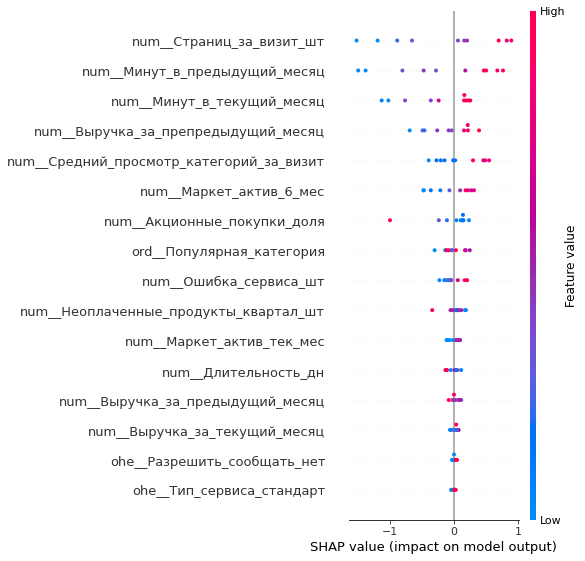

In [67]:
# Строим график важности признаков
shap.summary_plot(shap_values[:, :, 0], X_test_sampled_df)

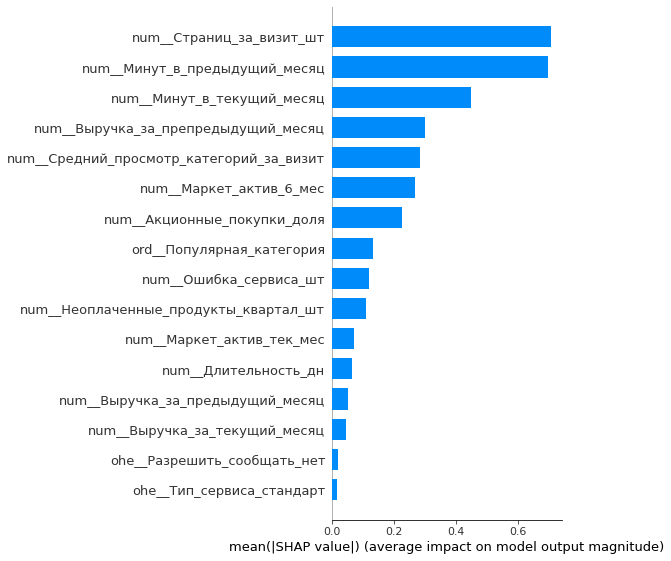

In [68]:
shap.summary_plot(shap_values[:, :, 0], plot_type = 'bar', feature_names=feature_names)

**Скриншоты графиков на основании данных 100 покупателей:**

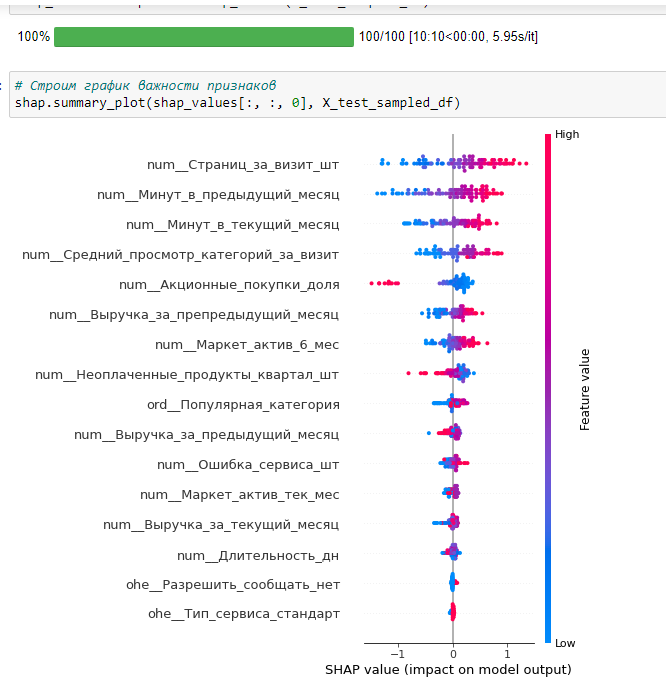

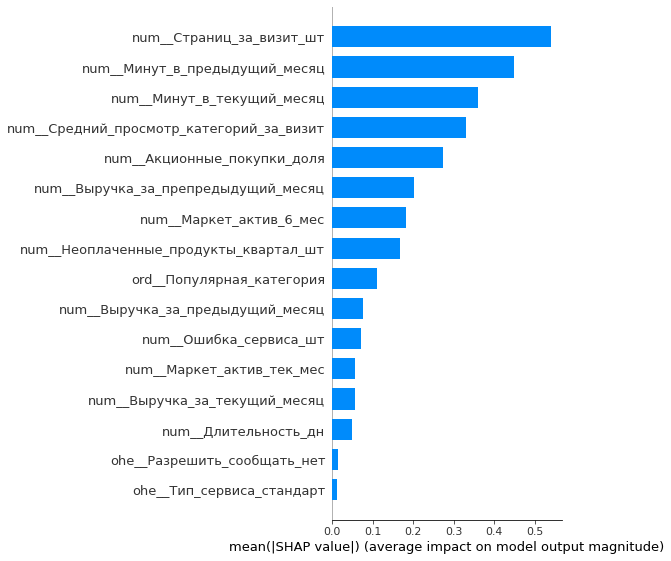

**На графиках признаки расположены в порядке убывания важности. Видим следующие результаты:**
- самыми значимыми являются:
    - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца
    - значение времени, проведённого на сайте за прошлый и текущий месяц
    - среднее количество категорий, просмотренных покупателем за визит в течение последнего месяца.
    - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев
- самыми малозначимыми являются:
    - тип сервиса
    - наличие согласия покупателя на информирование о предложениях
    - длительность с момента регистрации покупателя на сайте
    
**Можно сделать следующие выводы... На принятие решений модели по отнесению покупателя к активным покупателям, сильное влияние оказали такие признаки, как среднее количество просмотренных страниц за визит, время на сайте за прошлый и текущий месяц, среднее количество категорий, просмотренных покупателем за визит. Эти признаки относятся к категории "Поведение на сайте". То есть активность на сайте положительно связана с покупательской активностью. Рекомендуется дать задание профильному специалисту провести анализ юзабилити сайта для выявления наличия слабых мест, которые могут снижать метрики, относящиеся к категории "Поведение на сайте".**

**Среднемесячная доля покупок по акции от общего числа покупок наоборот имеет большое отрицательное влияние результат решения модели, то есть чем выше доля акционных покупок, тем более вероятно отнесение покупателя к категории тех, у кого прогнозируется снижение покупательской активности. Это может указывать на то, что пользователи, которые совершают больше акционных покупок, менее ценны в долгосрочной перспективе. Они могут быть менее лояльны к магазину и более чувствительны к цене. Однако для разработки рекомендаций необходимо более детально изучить данный сегмент.** 

**И наоборот, тип сервиса, наличие согласия покупателя на информирование о предложениях и длительность с момента регистрации покупателя на сайте меньше всего влияют на принятие решения моделью. Можно рекомендовать бизнесу реорганизовать или полностью расформировать систему премиального обслуживания, так как она не оправдывает себя, не оказывает влияние на лояльность покупателя и его покупательскую активность.**

**Также не стоит вкладывать ресурсы в рассылки информации о предложениях. С большой долей вероятности покупатели либо не читают информацию, либо вообще не получают по причине попадания писем в спам.**

**Длительность с момента регистрации покупателя на сайте также не стоит учитывать при разработке мотивационных программ, так как связь между покупательской активностью и длительностью с момента регистрации практически отсутствует.**

##  Сегментация покупателей

**Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.**

**Выберем группу покупателей и сделаем предложение, как увеличить её покупательскую активность:**
- Проведём графическое и аналитическое исследование группы покупателей.
- Сделаем предложения по работе с сегментом для увеличения покупательской активности.

**Возьмём тестовую выборку, добавим в неё предсказанные вероятности отнесения к классу 1, что соответствует сниженной покупательской активности, и объединим с данными о среднемесячной прибыли покупателя за последние 3 месяца.**

In [69]:
X_test = data_main.drop(columns=['Покупательская_активность'], axis=1)

In [70]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]

In [71]:
X_test['Вероятность_сниж_акт'] = y_test_pred

In [72]:
X_test.head()

id Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
0  215349     премиум                 да                 4.4   
1  215350    стандарт                нет                 4.9   
2  215351    стандарт                 да                 3.2   
3  215352    стандарт                нет                 5.1   
4  215353    стандарт                 да                 3.3   

   Маркет_актив_тек_мес  Длительность_дн  Акционные_покупки_доля  \
0                     4              819                    0.75   
1                     3              539                    0.14   
2                     5              896                    0.99   
3                     3             1064                    0.94   
4                     4              762                    0.26   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   Неоплаченные_продукты_квартал_шт  Ошибка_сервиса_шт  Страниц_за_визит_шт  \
0                                 4                  2                    5   
1                                 2                  1                    5   
2                                 0                  6                    4   
3                                 2                  3                    2   
4                                 1                  1                    4   

   Выручка_за_препредыдущий_месяц  Выручка_за_предыдущий_месяц  \
0                          4472.0                       5216.0   
1                          4826.0                       5457.5   
2                          4793.0                       6158.0   
3                          4594.0                       5807.5   
4                          5124.0                       4738.5   

   Выручка_за_текущий_месяц  Минут_в_предыдущий_месяц  Минут_в_текущий_месяц  \
0                    4971.6                        12                     10   
1                    5058.4                         8                     13   
2                    6610.4                        11                     13   
3                    5872.5                         8                     11   
4                    5388.5                        10                     10   

   Вероятность_сниж_акт  
0              0.926681  
1              0.642300  
2              0.789628  
3              0.953461  
4              0.840343

In [73]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Тип_сервиса                          1296 non-null   object 
 2   Разрешить_сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность_дн                      1296 non-null   int64  
 6   Акционные_покупки_доля               1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_квартал_шт     1296 non-null   int64  
 10  Ошибка_сервиса_шт                    1296 non-null   int64  
 11  Страниц_за_визит_шт           

In [74]:
X_test_prof = (X_test
             .merge(data_monthprof, on='id', how='inner')
             )

In [75]:
X_test_prof.head()

id Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
0  215349     премиум                 да                 4.4   
1  215350    стандарт                нет                 4.9   
2  215351    стандарт                 да                 3.2   
3  215352    стандарт                нет                 5.1   
4  215353    стандарт                 да                 3.3   

   Маркет_актив_тек_мес  Длительность_дн  Акционные_покупки_доля  \
0                     4              819                    0.75   
1                     3              539                    0.14   
2                     5              896                    0.99   
3                     3             1064                    0.94   
4                     4              762                    0.26   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   Неоплаченные_продукты_квартал_шт  Ошибка_сервиса_шт  Страниц_за_визит_шт  \
0                                 4                  2                    5   
1                                 2                  1                    5   
2                                 0                  6                    4   
3                                 2                  3                    2   
4                                 1                  1                    4   

   Выручка_за_препредыдущий_месяц  Выручка_за_предыдущий_месяц  \
0                          4472.0                       5216.0   
1                          4826.0                       5457.5   
2                          4793.0                       6158.0   
3                          4594.0                       5807.5   
4                          5124.0                       4738.5   

   Выручка_за_текущий_месяц  Минут_в_предыдущий_месяц  Минут_в_текущий_месяц  \
0                    4971.6                        12                     10   
1                    5058.4                         8                     13   
2                    6610.4                        11                     13   
3                    5872.5                         8                     11   
4                    5388.5                        10                     10   

   Вероятность_сниж_акт  Прибыль  
0              0.926681     4.16  
1              0.642300     3.13  
2              0.789628     4.87  
3              0.953461     4.21  
4              0.840343     3.95

In [76]:
X_test_prof.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Тип_сервиса                          1296 non-null   object 
 2   Разрешить_сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность_дн                      1296 non-null   int64  
 6   Акционные_покупки_доля               1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_квартал_шт     1296 non-null   int64  
 10  Ошибка_сервиса_шт                    1296 non-null   int64  
 11  Страниц_за_визит_шт           

In [77]:
X_test_prof.columns

Index(['id', 'Тип_сервиса', 'Разрешить_сообщать', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность_дн', 'Акционные_покупки_доля',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_квартал_шт', 'Ошибка_сервиса_шт',
       'Страниц_за_визит_шт', 'Выручка_за_препредыдущий_месяц',
       'Выручка_за_предыдущий_месяц', 'Выручка_за_текущий_месяц',
       'Минут_в_предыдущий_месяц', 'Минут_в_текущий_месяц',
       'Вероятность_сниж_акт', 'Прибыль'],
      dtype='object')

**Построим диаграммы рассеяния взаимосвязей признаков с предсказанной вероятностью снижения активности.**

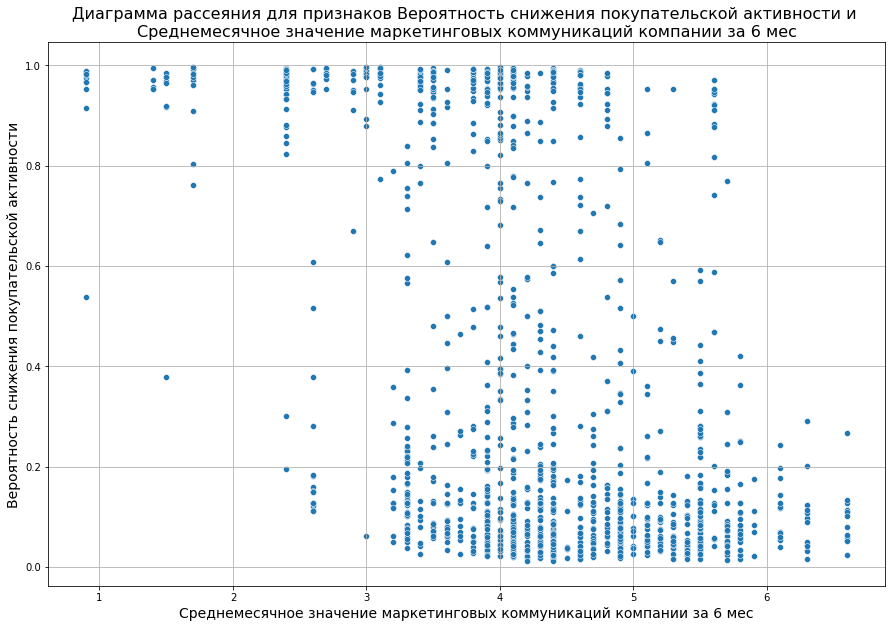

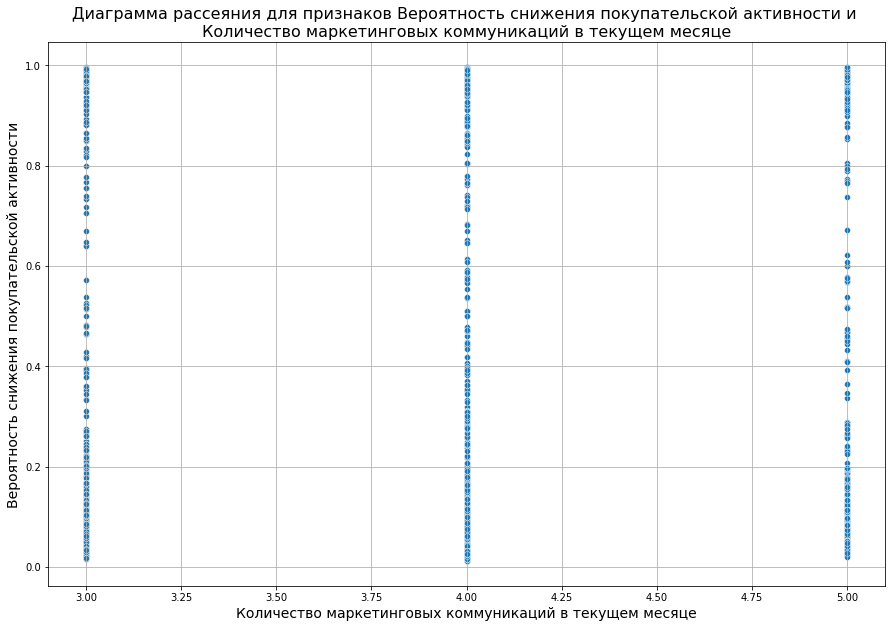

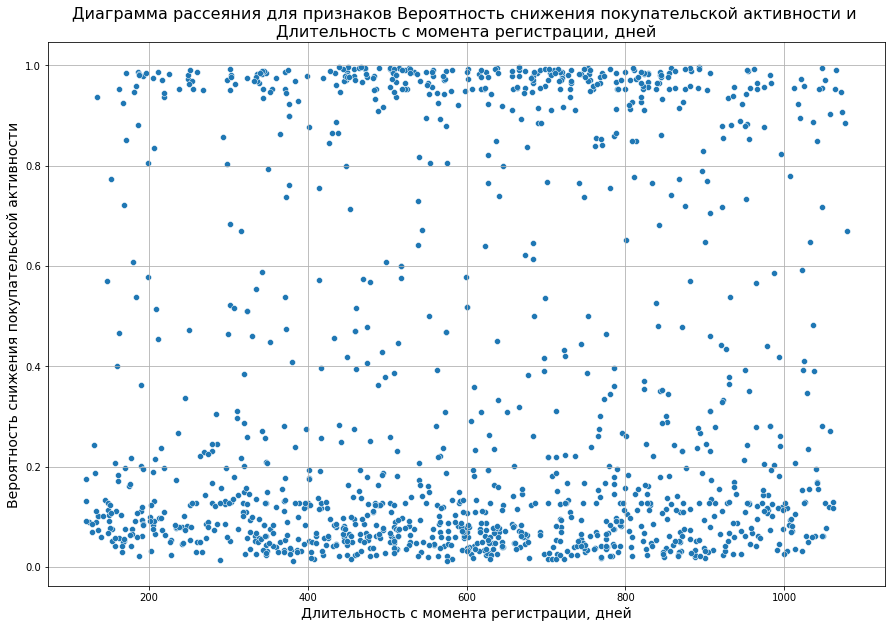

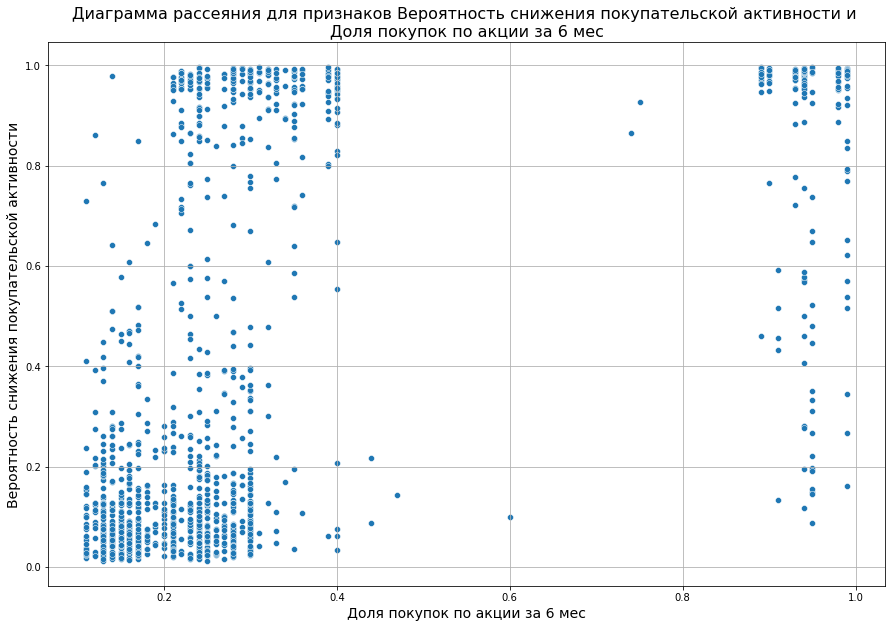

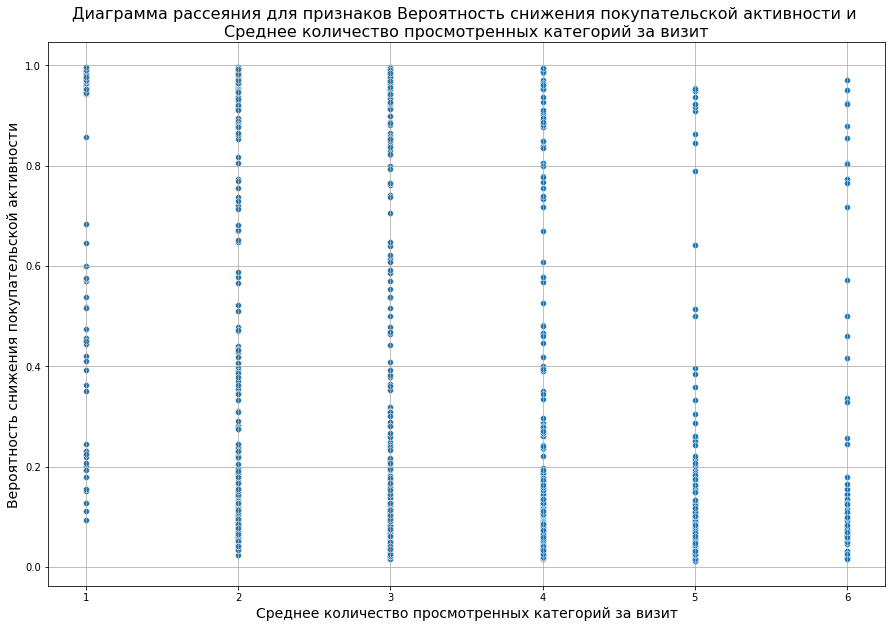

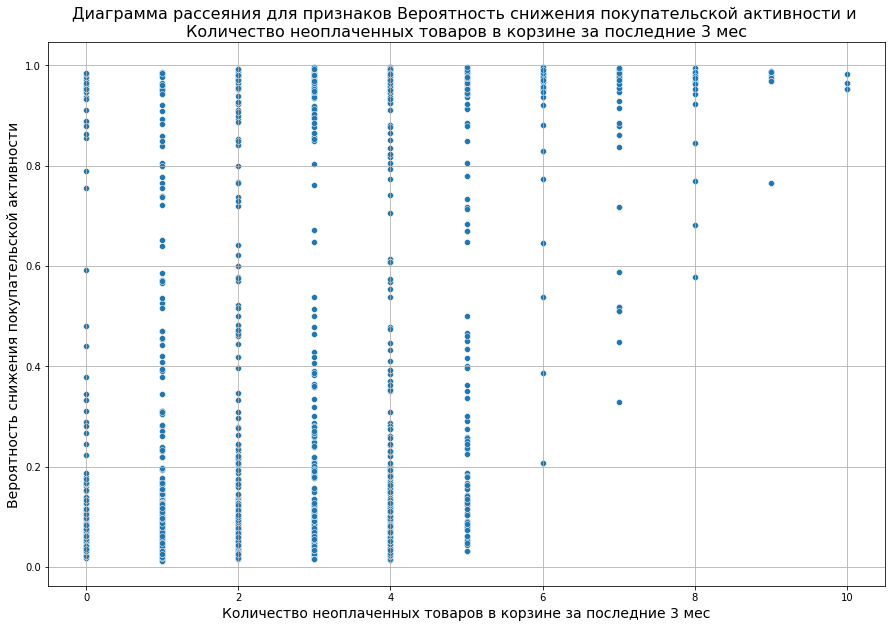

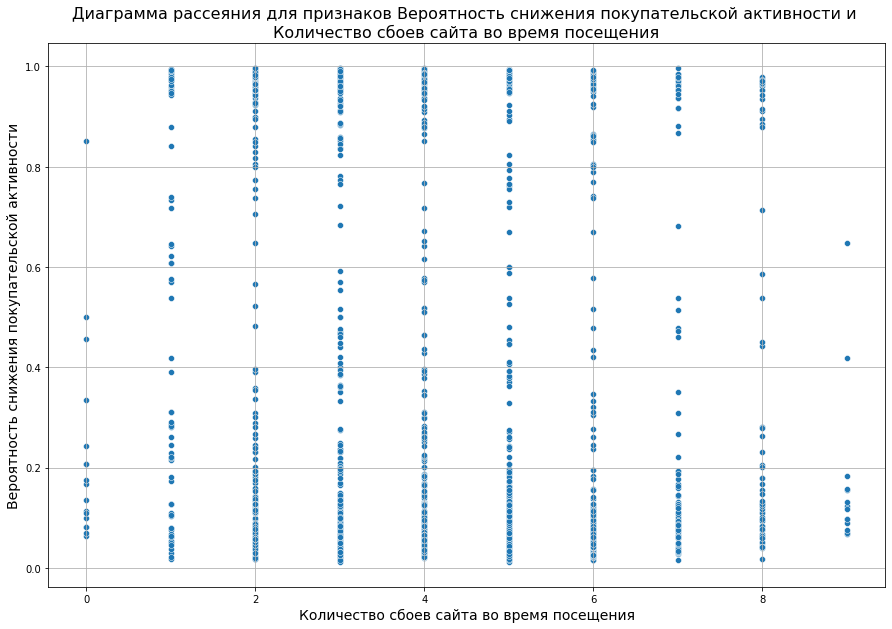

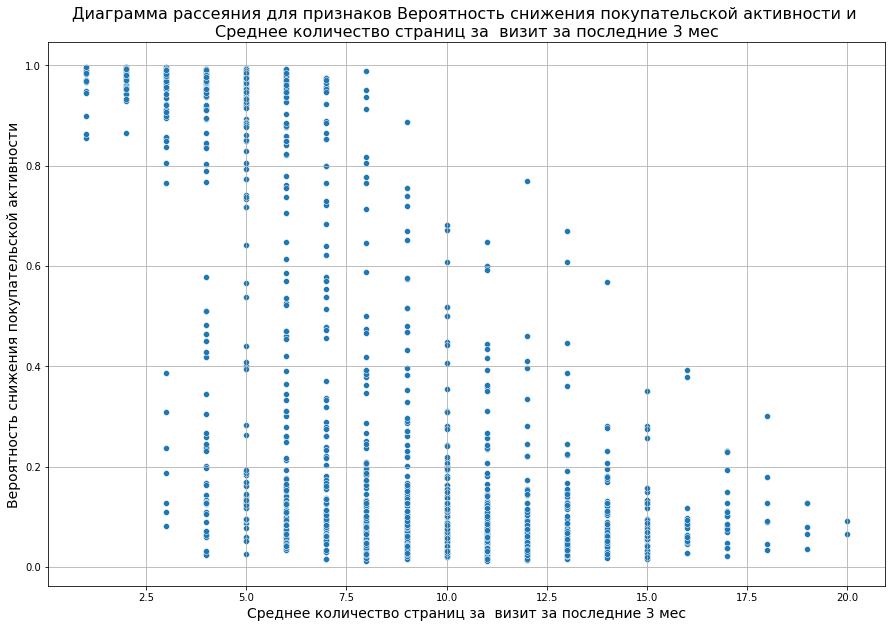

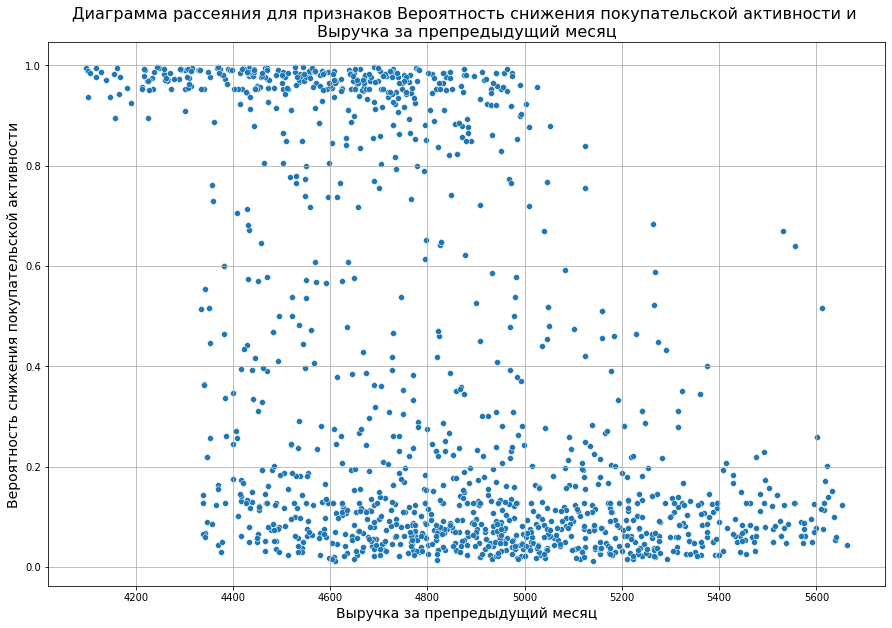

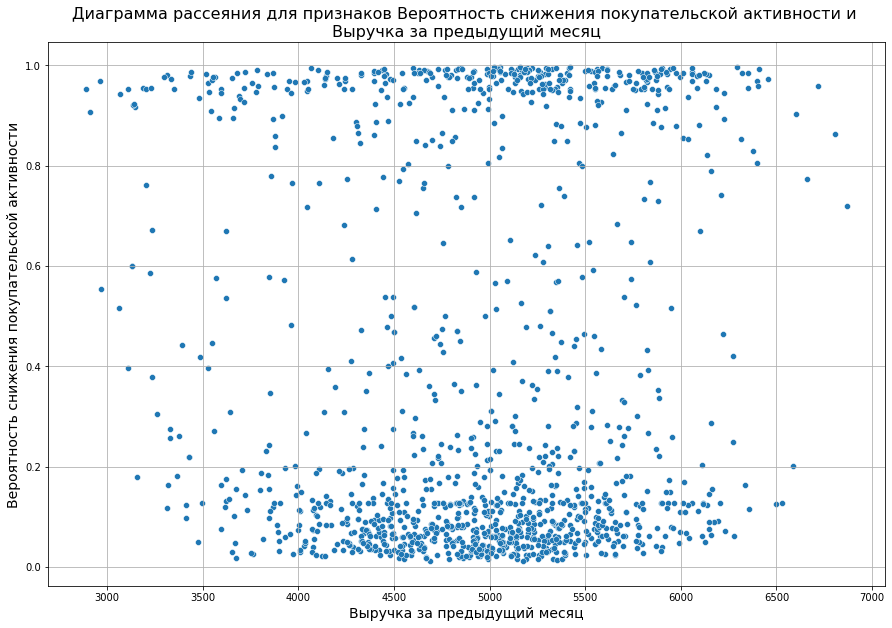

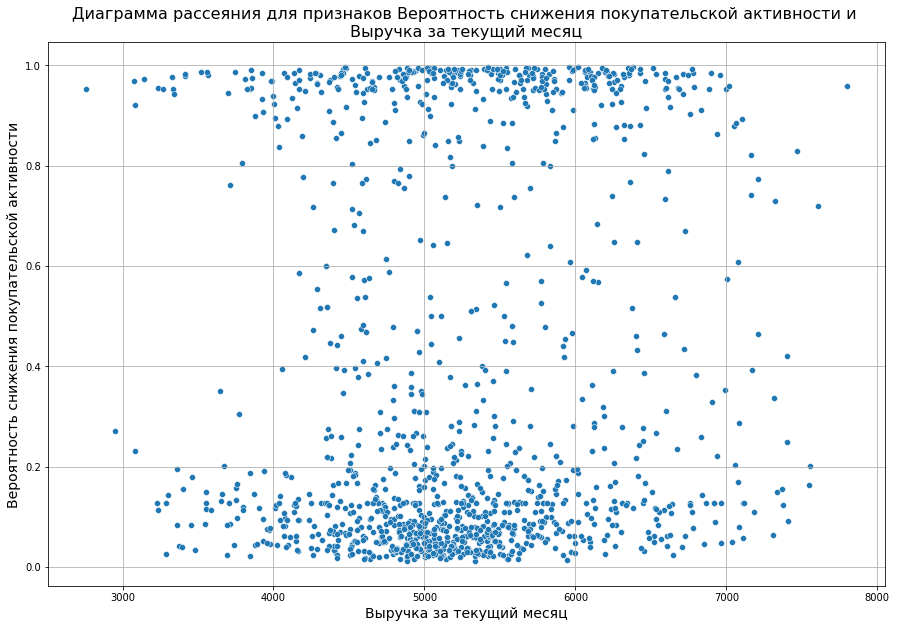

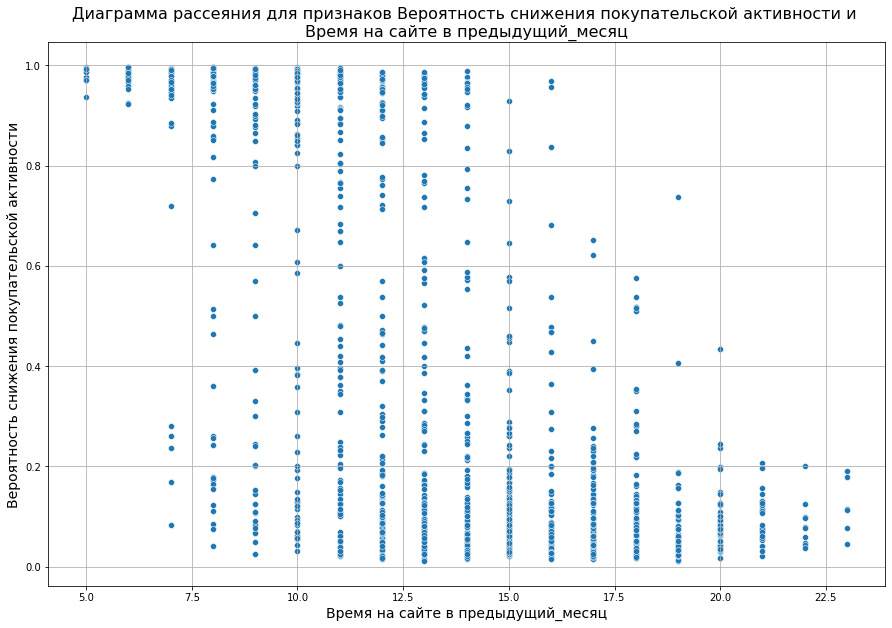

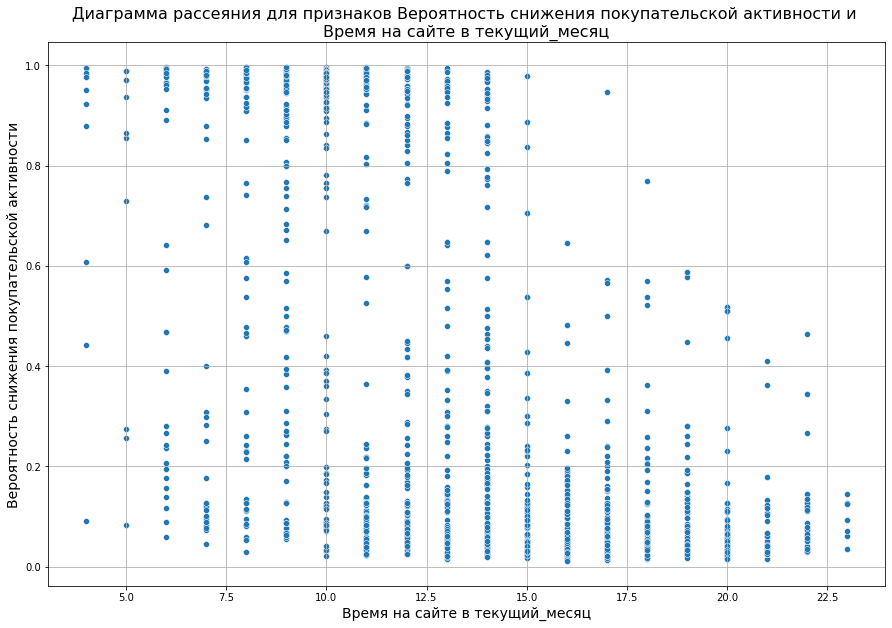

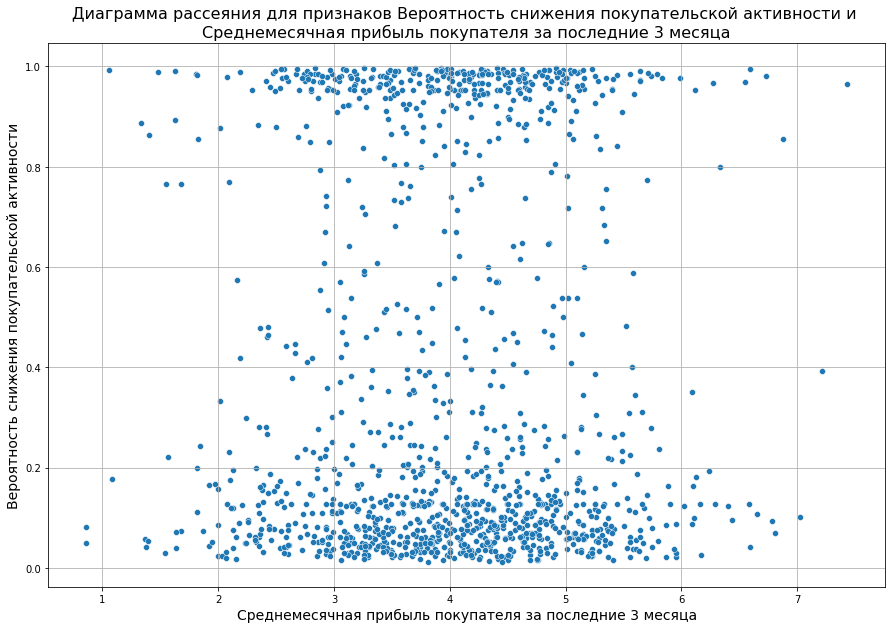

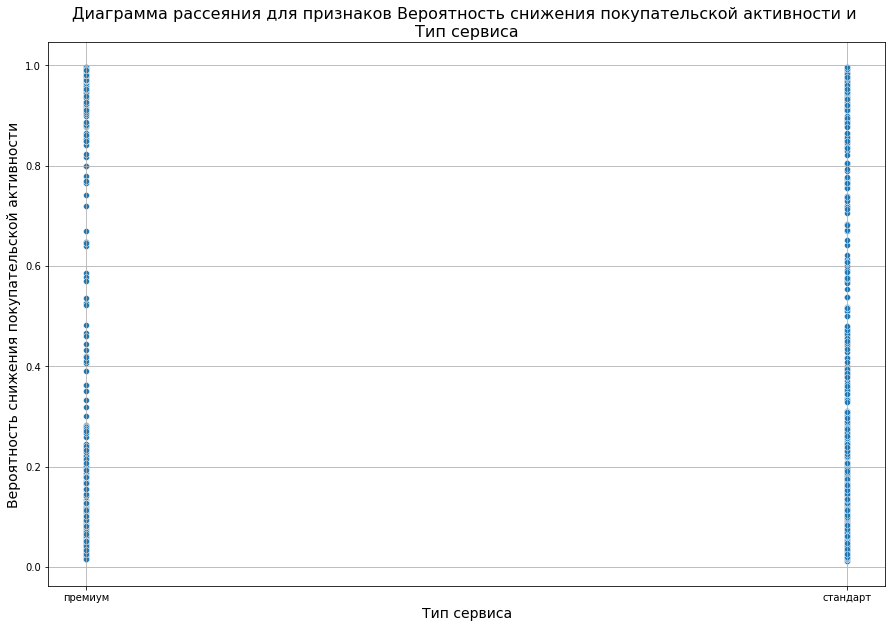

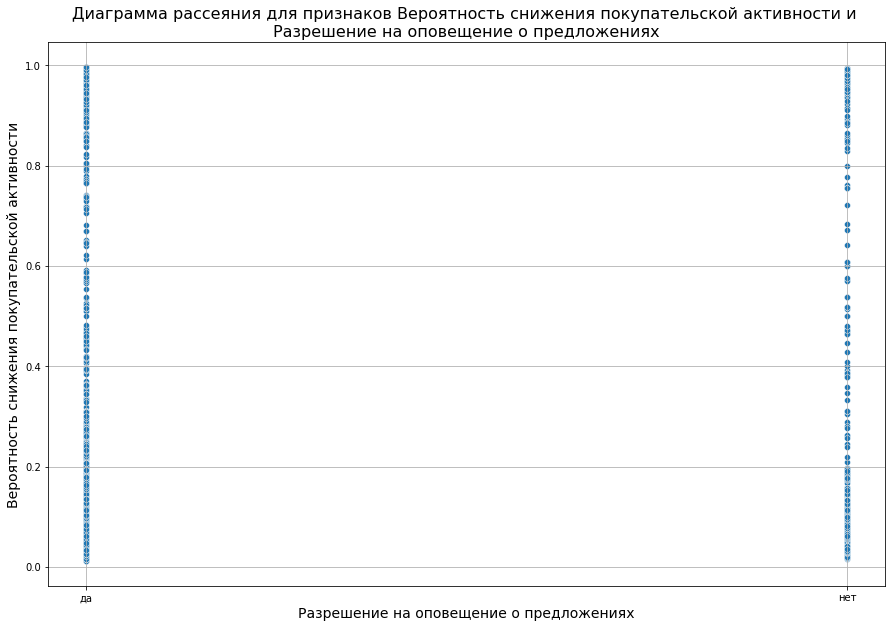

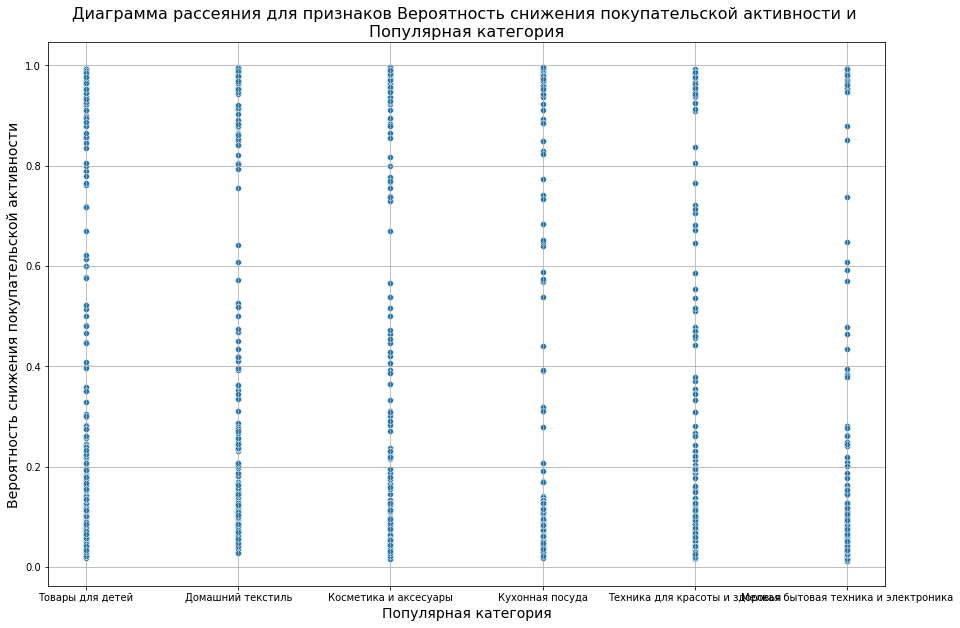

In [78]:
sign = ['Маркет_актив_6_мес',
        'Маркет_актив_тек_мес', 'Длительность_дн', 'Акционные_покупки_доля',
        'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_квартал_шт', 'Ошибка_сервиса_шт',
        'Страниц_за_визит_шт', 'Выручка_за_препредыдущий_месяц', 'Выручка_за_предыдущий_месяц', 
        'Выручка_за_текущий_месяц', 'Минут_в_предыдущий_месяц', 'Минут_в_текущий_месяц', 'Прибыль', 'Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']
sign_com = ['Среднемесячное значение маркетинговых коммуникаций компании за 6 мес',
            'Количество маркетинговых коммуникаций в текущем месяце', 
            'Длительность с момента регистрации, дней', 'Доля покупок по акции за 6 мес', 
            'Среднее количество просмотренных категорий за визит', 
            'Количество неоплаченных товаров в корзине за последние 3 мес',
            'Количество сбоев сайта во время посещения',
            'Cреднее количество страниц за  визит за последние 3 мес', 
            'Выручка за препредыдущий месяц', 'Выручка за предыдущий месяц', 'Выручка за текущий месяц',
            'Время на сайте в предыдущий_месяц', 'Время на сайте в текущий_месяц', 
            'Среднемесячная прибыль покупателя за последние 3 месяца', 'Тип сервиса', 'Разрешение на оповещение о предложениях', 'Популярная категория']
for n in range(0, len(sign)):
    plt.figure(figsize=(15, 10))
    sns.scatterplot(data=X_test_prof, x=sign[n], y='Вероятность_сниж_акт', palette='viridis')
    plt.title(f'Диаграмма рассеяния для признаков Вероятность снижения покупательской активности и \n{sign_com[n]}', fontsize=16)
    plt.xlabel(sign_com[n], fontsize=14)
    plt.ylabel('Вероятность снижения покупательской активности', fontsize=14)
    plt.grid(True)
    plt.show()

**По диаграммам можно выделить следующие интересные сегменты с высокой вероятностью снижения покупатльской активности, в которых сосредоточено довольно большое количество покупателей, в которых было бы полезно разобраться и выяснить возможности по сохранению их покупательской активности на высоком уровне:**
- с высокой выручкой за период (текущий, предыдущий, препредыдущий) и высокой вероятностью снижения покупательской активности (на этих диаграммах в этом сегменте сосредоточено довольно много покупателей)
- с высокой среднемесячной прибылью от покупателя за 3 месяца и высокой вероятностью снижения покупательской активности (довольно много покупателей)
- покупатели типа сервиса «премиум» с  высокой вероятностью снижения покупательской активностью (на этих диаграммах в этом сегменте сосредоточено довольно много покупателей)
- покупатели с наибольшей активностью в категориях товаров для дома (кухонная посуда, домашний текстиль) и товары для детей и высокой вероятностью снижения покупательской активности
- покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.


**Проведём графическое и аналитическое исследование группы покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. Отберём покупателей с показателем вероятности снижения активность более 0.5 и с долей покупок по акции более 0.8.**

In [79]:
group_max_promo = X_test_prof.query('Акционные_покупки_доля>0.8 & Вероятность_сниж_акт>0.5')

In [80]:
group_max_promo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 2 to 1252
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   135 non-null    int64  
 1   Тип_сервиса                          135 non-null    object 
 2   Разрешить_сообщать                   135 non-null    object 
 3   Маркет_актив_6_мес                   135 non-null    float64
 4   Маркет_актив_тек_мес                 135 non-null    int64  
 5   Длительность_дн                      135 non-null    int64  
 6   Акционные_покупки_доля               135 non-null    float64
 7   Популярная_категория                 135 non-null    object 
 8   Средний_просмотр_категорий_за_визит  135 non-null    int64  
 9   Неоплаченные_продукты_квартал_шт     135 non-null    int64  
 10  Ошибка_сервиса_шт                    135 non-null    int64  
 11  Страниц_за_визит_шт            

**Проведём анализ этой группы в сравнении с покупателями имеющими вероятность отнесения к классу 1 (снижение покупательской активности) менее 0.5.**

In [81]:
group_act = X_test_prof.query('Вероятность_сниж_акт<0.5')

In [82]:
group_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869 entries, 6 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   869 non-null    int64  
 1   Тип_сервиса                          869 non-null    object 
 2   Разрешить_сообщать                   869 non-null    object 
 3   Маркет_актив_6_мес                   869 non-null    float64
 4   Маркет_актив_тек_мес                 869 non-null    int64  
 5   Длительность_дн                      869 non-null    int64  
 6   Акционные_покупки_доля               869 non-null    float64
 7   Популярная_категория                 869 non-null    object 
 8   Средний_просмотр_категорий_за_визит  869 non-null    int64  
 9   Неоплаченные_продукты_квартал_шт     869 non-null    int64  
 10  Ошибка_сервиса_шт                    869 non-null    int64  
 11  Страниц_за_визит_шт            

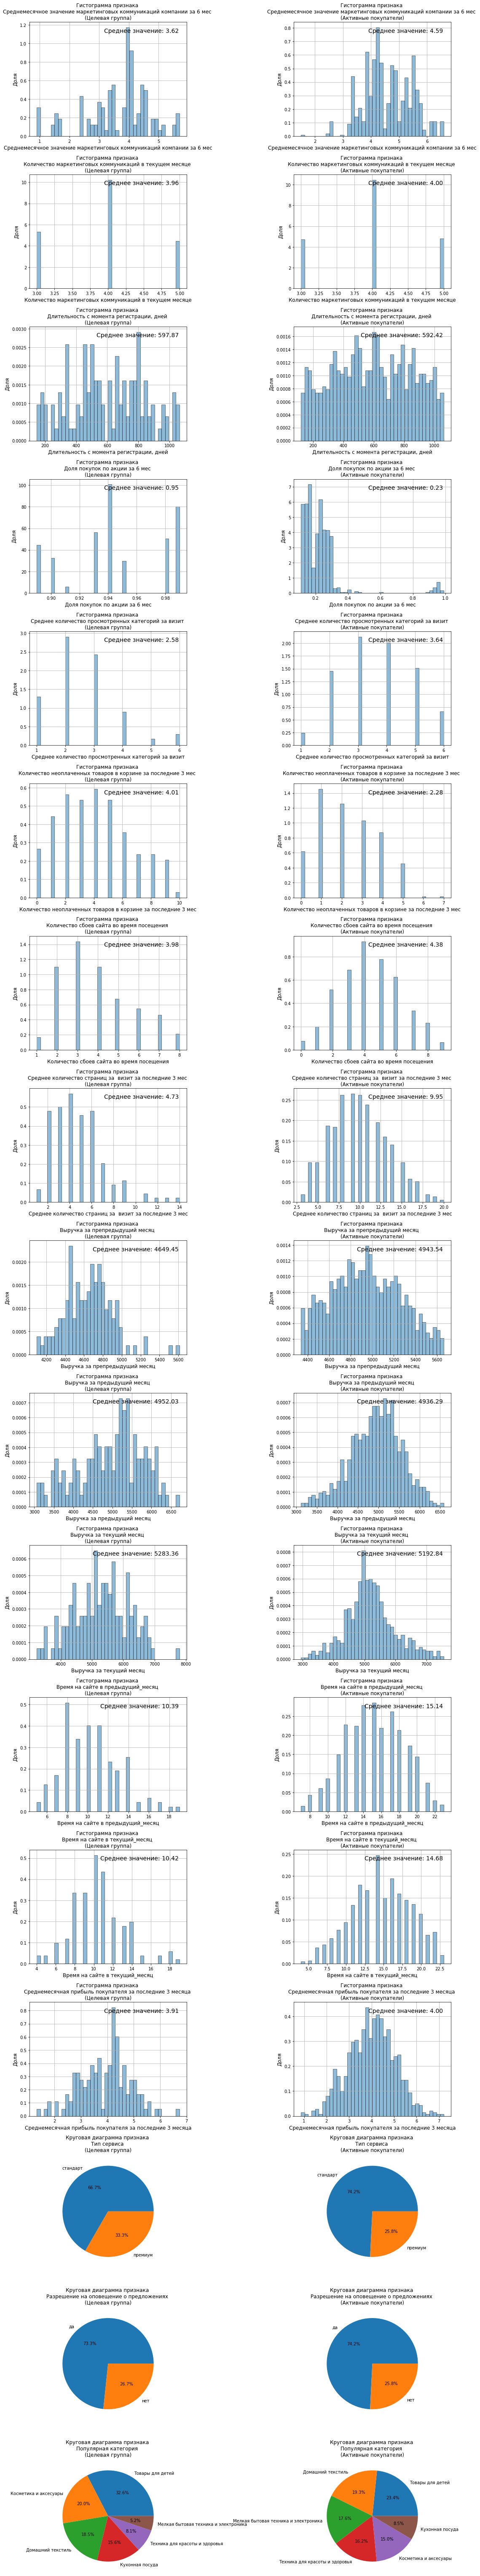

In [83]:
fig, axes = plt.subplots(nrows=len(sign), ncols=2, figsize=(15, 5 * len(sign)))
for i, (s, s_com) in enumerate(zip(sign, sign_com)):
    for j, (subset, label) in enumerate([[group_max_promo, 'Целевая группа'], [group_act, 'Активные покупатели']]):
        if pd.api.types.is_numeric_dtype(subset[s]):            
            axes[i, j].hist(subset[s], bins=40, alpha=0.5, edgecolor = 'black', density=True)
            axes[i, j].grid(True)
            axes[i, j].set_xlabel(s_com, fontsize=12)
            axes[i, j].set_ylabel('Доля', fontsize=12)
            axes[i, j].set_title(f'Гистограмма признака \n{s_com} \n({label})', fontsize=12)
            mean_value = subset[s].mean()
            axes[i, j].text(0.95, 0.95, f'Среднее значение: {mean_value:.2f}', transform=axes[i, j].transAxes,
                            fontsize=14, verticalalignment='top', horizontalalignment='right')
        else:            
            value_counts = subset[s].value_counts(normalize=True)
            axes[i, j].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
            axes[i, j].set_title(f'Круговая диаграмма признака \n{s_com} \n({label})', fontsize=12)
plt.tight_layout()
plt.show()

**По диаграммам можно выделить следующие различия между нашей целевой группой (покупателями с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности) и активными покупателями (для которых не прогнозируется снижение активности).:**
- `Среднемесячное значение маркетинговых коммуникаций компании за 6 мес` – среднее значение у целевой группы ниже, чем у активных покупателей.
- `Среднее количество просмотренных категорий за визит` – среднее значение у целевой группы ниже, чем у активных покупателей.
- `Количество неоплаченных товаров в корзине за последние 3 мес` -  среднее значение у целевой группы выше, чем у активных покупателей.
- `Cреднее количество страниц за  визит за последние 3 мес` - среднее значение у целевой группы значительно ниже, чем у активных покупателей.
- `Выручка за препредыдущий месяц` , `Выручка за предыдущий месяц`  и `Выручка за текущий месяц` – в среднем различия за 3 месяца незначительны, однако в отличие от активных пользователей наблюдаем у нашей целевой группы положительную динамику по выручке. В препредыдущий месяц она была ниже, чем у активных пользователей, а в текущий месяц даже немного превысила.
- `Время на сайте в предыдущий месяц`  и  `Время на сайте в текущий месяц` – среднее значение у целевой группы значительно ниже, чем у активных покупателей.
- `Среднемесячная прибыль покупателя за последние 3 месяца` –  различия незначительны.
- `Тип сервиса` – у целевой группы немного больше доля покупателей с типом сервиса «премиум».
- `Разрешение на оповещение о предложениях` –  различия незначительны.
- `Популярная категория` – у целевой группы в большей степени преобладают категории товаров для детей, кухонная посуда, косметика и аксессуары и в значительно меньшей степени техника для красоты и здоровья и мелкая бытовая техника и электроника.

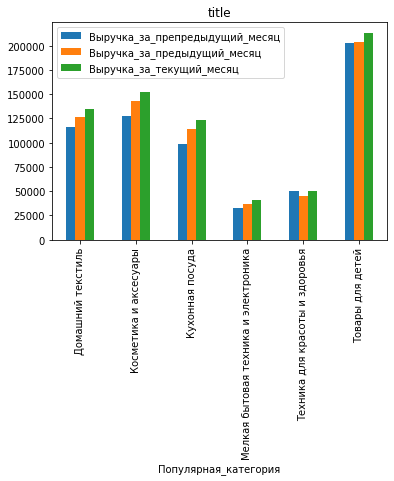

In [88]:
# код ревьюера
group_max_promo.groupby('Популярная_категория')[["Выручка_за_препредыдущий_месяц","Выручка_за_предыдущий_месяц","Выручка_за_текущий_месяц"]]\
            .sum().plot(kind='bar', title='title');

**Из вышеописанных наблюдений можно выделить следующием моменты:**
- По наблюдениям в популярных категориях можно заметить, что в покупках нашей целевой группы преобладают те же категории, что и у активных покупателей, однако имеются различия в размерах долей - у целевой группы больше доля категории товаров для детей, кухонная посуда, косметика и аксессуары.
- У нашей целевой группы имеется положительная динамика по выручке.
- У нашей целевой группы выше доля покупателей с премиальным типом сервиса.
- Количество неоплаченных товаров в корзине за последние 3 мес у целевой группы выше, чем у активных покупателей.
- Среднее количество просмотренных страниц за визит, время на сайте за прошлый и текущий месяц, среднее количество категорий, просмотренных покупателем за визит - это признаки, относящиеся к категории "Поведение на сайте" - они у нашей целевой группы имеют худшие показатели. 

**На основании вышеописанного можно сделать вывод, что у нашей целевой группы имеется потенциал, есть положительная динамика по выручке и средняя выручка не ниже активных покупателей, плюс доля покупателей с премиальным сервисом выше, чем у активных покупателей, однако необходимо устранить проблемы, ведущие к снижению активности. Для точных выводов у нас недостаточно данных, можем дать рекомендации:**
- при наличии технической возможности, предоставить данные по категориям товаров в разрезе периодов для анализа динамики по категориям
- предоставить информацию по срокам действия, категориям распространения акций и доле товаров с акционным предложением от общего количества в категории для анализа взаимосвязи динамики активности в категории и акционными предложениями (в случае, если акция действовала не на всю категорию, а на определенные товары, важно знать, акция затрагивала 0,0001% от всех товаров или 50%). 
- разработать дополнительную систему мотивации и акционные предложения, преимущественно по категориям товаров для детей, кухонная посуда, косметика и аксессуары, для сохранения активности сегмента покупателей, которые покупают только по акциям (пока что сосредоточиться на этих категориях, однако после предоставления данных по категориям и прошедшим акциям в разрезе периодов, появится возможность уточнения рекомендаций).
- дать задание профильному специалисту провести анализ юзабилити сайта для выявления наличия слабых мест, которые могут снижать метрики, относящиеся к категории "Поведение на сайте". Необходимо  выяснить причины слабой активности на сайте целевой группы и причины большого количества неоплаченных товаров в корзине. Это можно выявить по более детальным метрикам сайта и тепловым картам сайта. Возможные проблемы - неудобное меню сайта, неудобная сортировка товаров в каталоге, плохое описание товаров, недостаточно вариантов оплаты, неудобные варианты доставки и т.п. Всё это можно обнаружить по детальным метрикам. Например, покупатель положил в корзину детские подгузники, но на этапе оформления на разделе доставки остановился (или на разделе выбора формы оплаты). 

##  Общие выводы

**В процессе выполнения данной работы было сделано следующее:**
- Проведена предобработка данных, удалены неявные дубликаты.
- Провели исследовательский анализ данных, удалили выбросы, а также отобрали покупателей с активностью не менее 3 месяцев.
- Объединили данные исходных таблиц.
- Провели корреляционный анализ, в ходе которого обнаружили следующие взаимосвязи:
    - средний уровень корреляции покупательской активности с:
        - долей акционных покупок,
        - среднемесячным значением маркетинговых коммуникаций на покупателя за последние 6 месяцев
        - средним просмотром категорий за визит
        - количеством неоплаченных продуктов за квартал
        - выручкой за препредыдущий месяц
    - высокий уровень корреляции покупательской активности с:
        - средним количеством просмотренных страниц за визит
        - временем, проведённом на сайте в текущем и предыдущем периоде
    - отсутствие мультиколлинеарности между признаками.
- Были сформированы пайплайны, с помощью которых было обучено 4 модели:
    - KNeighborsClassifier()
    - DecisionTreeClassifier()
    - LogisticRegression()
    - SVC()
    - Для каждой из моделей были подобраны гиперпараметры, во время подготовки данных был использован ColumnTransformer, количественные и категориальные признаки обработаны в пайплайне раздельно, для кодирования категориальных признаков использованы OneHotEncoder и OrdinalEncoder, для масштабирования количественных — StandardScaler и MinMaxScaler. 
    - Лучшей моделью оказался метод опорных векторов (SVC) с параметрами:
        - Ядро радиальной базисной функции (RBF)
        - параметр регуляризации С = 0.3
        - probability=True
        - метод масштабирования StandardScaler()
        - Метрика лучшей модели на тренировочной выборке: 0.8986125599278173
        - Метрика ROC-AUC на тестовой выборке: 0.90875
- Была проведена оценка важности признаков для лучшей модели и построен график важности с помощью метода SHAP. На графиках признаки расположены в порядке убывания важности, видим следующие результаты:
    - самыми значимыми являются:
        - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца
        - значение времени, проведённого на сайте за прошлый и текущий месяц
        - среднее количество категорий, просмотренных покупателем за визит в течение последнего месяца
        - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев
    - самыми малозначимыми являются:
        - тип сервиса
        - наличие согласия покупателя на информирование о предложениях
        - длительность с момента регистрации покупателя на сайте
- Выполнена сегментация покупателей. Проведено графическое и аналитическое исследование группы покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. Получены следующие результаты:
    - `Среднемесячное значение маркетинговых коммуникаций компании за 6 мес` – среднее значение у целевой группы ниже, чем у активных покупателей.
    - `Среднее количество просмотренных категорий за визит` – среднее значение у целевой группы ниже, чем у активных покупателей.
    - `Количество неоплаченных товаров в корзине за последние 3 мес` -  среднее значение у целевой группы выше, чем у активных покупателей.
    - `Cреднее количество страниц за  визит за последние 3 мес` - среднее значение у целевой группы значительно ниже, чем у активных покупателей.
    - `Выручка за препредыдущий месяц` , `Выручка за предыдущий месяц`  и `Выручка за текущий месяц` – в среднем различия за 3 месяца незначительны, однако в отличие от активных пользователей наблюдаем у нашей целевой группы положительную динамику по выручке. В препредыдущий месяц она была ниже, чем у активных пользователей, а в текущий месяц даже немного превысила.
    - `Время на сайте в предыдущий месяц`  и  `Время на сайте в текущий месяц` – среднее значение у целевой группы значительно ниже, чем у активных покупателей.
    - `Среднемесячная прибыль покупателя за последние 3 месяца` –  различия незначительны.
    - `Тип сервиса` – у целевой группы немного больше доля покупателей с типом сервиса «премиум».
    - `Разрешение на оповещение о предложениях` –  различия незначительны.
    - `Популярная категория` – у целевой группы в большей степени преобладают категории товаров для детей, кухонная посуда, косметика и аксессуары и в значительно меньшей степени техника для красоты и здоровья и мелкая бытовая техника и электроника.


**Рекомендации:**
- Дать задание профильному специалисту провести анализ юзабилити сайта для выявления наличия слабых мест, которые могут снижать метрики, относящиеся к категории "Поведение на сайте".
- Предоставить информацию по срокам действия, категориям распространения акций и доле товаров с акционным предложением от общего количества в категории для анализа взаимосвязи динамики активности в категории и акционными предложениями. 
- Разработать дополнительную систему мотивации и акционные предложения, преимущественно по категориям товаров для детей, кухонная посуда, косметика и аксессуары, для сохранения активности сегмента покупателей, которые покупают только по акциям (пока что сосредоточиться на этих категориях, однако после предоставления данных по категориям и прошедшим акциям в разрезе периодов, появится возможность уточнения рекомендаций).
- Реорганизовать или полностью расформировать систему премиального обслуживания, так как она не оправдывает себя, не оказывает влияние на лояльность покупателя и его покупательскую активность.
- Также не стоит вкладывать ресурсы в рассылки информации о предложениях. С большой долей вероятности покупатели либо не читают информацию, либо вообще не получают по причине попадания писем в спам.
- Длительность с момента регистрации покупателя на сайте не стоит учитывать при разработке мотивационных программ, так как связь между покупательской активностью и длительностью с момента регистрации практически отсутствует.